# Collaborative Filtering Based on Timebin Neighbourhood

Classes:

* [Dataset](#Dataset)
 * [Netflix Dataset](#NetflixDataset)
 * [Movielens Dataset](#MovielensDataset)
 
 
* [Time Constraint](#TimeConstraint)


* [Accuracy](#Accuracy)
 * [MovieLens Accuracy](#MovieLensAccuracy)
 * [Netflix Accuracy](#NetflixAccuracy)


* [TrainsetUser](#TrainsetUser)
* [TrainsetMovie](#TrainsetMovie)


* [Pearson](#Pearson)


* [Trainset](#Trainset)


* [TimebinSimilarity](#TimebinSimilarity)

In [1]:
from abc import ABC, abstractmethod
from datetime import datetime
from datetime import timedelta
from collections import defaultdict
from timeit import default_timer
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import math
import random
from random import sample
from collections import deque  # To shift lists

## Dataset

Dataset is the bases class of all datasets. Defines the basic load method which has to be defined by every subclass of the dataset.
* Currently Supported Datasets:
  * Netflix Dataset
  * Movielens Dataset

In [2]:
class Dataset(ABC):
    """
    Dataset class and its subclasses provides utilities in order to import datasets.
    
    """
    @staticmethod
    @abstractmethod
    def load():
        """ Every subclass must provide static load method"""
        pass

### NetflixDataset

[Netflix Dataset](https://www.kaggle.com/netflix-inc/netflix-prize-data) consists of over 100million ratings with 470k users.

But the problem is, the test machine that we use can not handle more than half a million ratings. That is why we had to truncate most of the data out of the dataset.
* The way we truncate the dataset is as follows:
  1. We only take 1 out of 4 combined data which all together constructs the netflix prize dataset.
  2. Then we drop the duplicate users where they have mean rating in common or number of ratings given in common.
  3. At the end of the all these, we get a dataset which has 4499 movies, 480k ratings data with 850 users.

In [3]:
class NetflixDataset(Dataset):
    
    def __init__(self, ratings_col_names=('user_id', 'rating', 'timestamp'),
                       ratings_path=r'C:\Users\Yukawa\datasets\netflix\combined_data_1.txt',
                       movies_col_names=('item_id', 'year', 'title'),
                       movies_path=r'C:\Users\Yukawa\datasets\netflix\movie_titles.csv',
                       is_ratings_cached=True, is_movies_cached=True, 
                       is_movie_ratings_cached=True):
        Dataset.__init__(self)
        self.is_ratings_cached = is_ratings_cached
        self.is_movies_cached = is_movies_cached
        self.ratings = NetflixDataset.load_ratings(ratings_path, 
                                                   ratings_col_names) if self.is_ratings_cached else None
        self.movies = NetflixDataset.load_movies(movies_path,
                                                   movies_col_names) if self.is_movies_cached else None
        self.is_movie_ratings_cached = is_movie_ratings_cached
        self.movie_ratings = NetflixDataset.create_movie_ratings(self.ratings, 
                                                                 self.movies) if self.is_movie_ratings_cached else None
        
    @staticmethod
    def load_movies(movies_path,
                    movies_col_names=('item_id', 'year', 'title')):
        
        
        movies = pd.read_csv(movies_path, encoding='ISO-8859-1', header=None, names=movies_col_names).set_index('item_id')
        movies['year'].replace([np.inf, -np.inf, np.nan], 0, inplace=True)
        movies['year'] = movies['year'].astype(int)
        movies = movies.reindex(columns=['title', 'year'])
        
        # From the netflix prize dataset, I will only be using the first part which contains 4449 unique movies. 
        # That is why I will be truncating the other movies but if you load all the netflix data, remove this line.
        movies = movies[:4499]    # Keep only the first 4499 movies of the dataset
        
        return movies
    
    @staticmethod
    def load_ratings(ratings_path,
                     ratings_col_names=('user_id', 'rating', 'timestamp')):    
        if not os.path.isfile(ratings_path) or not ratings_col_names:
            return None
        
        ratings_raw = pd.read_csv(ratings_path, header=None, names=['user_id', 'rating', 'timestamp'], usecols=[0, 1, 2])
        ratings_raw['rating'] = ratings_raw['rating'].astype(float)
        # Find empty rows to slice dataframe for each movie
        temp_movies = ratings_raw[ratings_raw['rating'].isna()]['user_id'].reset_index()
        movie_indexes = [[index, int(movie[:-1])] for index, movie in temp_movies.values]

        # Shift the movie_indexes by one to get start and endpoints of all movies
        shifted_movie_indexes = deque(movie_indexes)
        shifted_movie_indexes.rotate(-1)

        # Gather all dataframes
        user_data = []
        for [df_id_1, movie_id], [df_id_2, next_movie_id] in zip(movie_indexes, shifted_movie_indexes):

            # if it is the last movie in the file
            if df_id_1 < df_id_2:
                temp_df = ratings_raw[(df_id_1+1):(df_id_2-1)].copy()
            else:
                temp_df = ratings_raw[df_id_1+1:].copy()

            # Create movie id column
            temp_df['item_id'] = movie_id

            # Append dataframe to list

            user_data.append(temp_df)

        # Combile all  dataframes
        ratings = pd.concat(user_data)
        del user_data, ratings_raw, temp_movies, temp_df, shifted_movie_indexes, movie_indexes, df_id_1, df_id_2, movie_id, next_movie_id
        
        # Convert the column order to the same order as the MovieLens dataset for ease of use
        ratings = ratings.reindex(columns=['user_id', 'item_id', 'rating', 'timestamp'])
        
        # Convert the string timestamps into datetime type
        ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], infer_datetime_format=True)
        
        # Convert the string user ids into int
        ratings['user_id'] = ratings['user_id'].astype(int)
        
        #### !!! Drop These two lines if No Memory and Time Constraint are set.
        netflix_users = NetflixDataset.get_filtered_netflix_users(ratings)
        ratings = ratings.loc[ (ratings['user_id'].isin(netflix_users)) ]
        
        return ratings
    
    @staticmethod
    def get_filtered_netflix_users(ratings):
        data = ratings
        active_users = pd.DataFrame(data.groupby('user_id')['rating'].mean())
        active_users['No_of_ratings'] = pd.DataFrame(data.groupby('user_id')['rating'].count())
        active_users.sort_values(by=['No_of_ratings'], ascending=False, inplace=True)
        active_users.columns = ['mean_rating', 'No_of_ratings']
        return active_users.loc[active_users['No_of_ratings'] > 40].drop_duplicates('mean_rating').drop_duplicates('No_of_ratings').index.values
    
    
    @staticmethod
    def create_movie_ratings(ratings, movies):
        return pd.merge(ratings, movies, on='item_id')
    
    
    @staticmethod
    def load(ratings_col_names=('user_id', 'rating', 'timestamp'),
             ratings_path=r'C:\Users\Yukawa\datasets\netflix\combined_data_1.txt',
             movies_col_names=('item_id', 'year', 'title'),
             movies_path=r'C:\Users\Yukawa\datasets\netflix\movie_titles.csv'):
        
        # Load movies
        movies = NetflixDataset.load_movies(movies_path=movies_path, movies_col_names=movies_col_names)
        
        # Load Ratings
        ratings = NetflixDataset.load_ratings(ratings_path=ratings_path, ratings_col_names=ratings_col_names)
        
        # Merge the ratings and movies
        movie_ratings = NetflixDataset.create_movie_ratings(ratings, movies)
        
        return movie_ratings

### MovielensDataset

[The Movie Lens Latest Small Dataset](https://grouplens.org/datasets/movielens/) has 100,000 ratings and 9,000 movies with 600 users.

In [4]:
class MovieLensDataset(Dataset):
    def __init__(self,
                 ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
                 ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
                 movies_col_names=('item_id', 'title', 'genres'),
                 movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv',
                 is_ratings_cached=True,
                 is_movies_cached=True, 
                 is_movie_ratings_cached=True):
        Dataset.__init__(self)
        self.is_ratings_cached = is_ratings_cached
        self.is_movies_cached = is_movies_cached
        self.ratings = MovieLensDataset.load_ratings(ratings_path,
                                                     ratings_col_names) if self.is_ratings_cached else None
        self.movies = MovieLensDataset.load_movies(movies_path,
                                                   movies_col_names) if self.is_movies_cached else None
        self.is_movie_ratings_cached = is_movie_ratings_cached
        self.movie_ratings = MovieLensDataset.create_movie_ratings(self.ratings, 
                                                                 self.movies) if self.is_movie_ratings_cached else None
        
    @staticmethod
    def load_movies(movies_path,
                    movies_col_names=('item_id', 'title', 'genres')):
        if not os.path.isfile(movies_path) or not movies_col_names:
            return None

        # read movies
        movies = pd.read_csv(movies_path, sep=',', header=1, names=movies_col_names)

        # Extract Movie Year
        movies['year'] = movies.title.str.extract("\((\d{4})\)", expand=True)
        movies.year = pd.to_datetime(movies.year, format='%Y')
        movies.year = movies.year.dt.year  # As there are some NaN years, resulting type will be float (decimals)

        # Remove year part from the title
        movies.title = movies.title.str[:-7]

        return movies

    @staticmethod
    def load_ratings(ratings_path,
                     ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp')):
        if not os.path.isfile(ratings_path) or not ratings_col_names:
            return None

        # read ratings
        ratings = pd.read_csv(ratings_path, sep=',', header=1, names=ratings_col_names)

        # Convert timestamp into readable format
        ratings['timestamp'] = pd.to_datetime(ratings['timestamp'], unit='s', origin='unix')

        return ratings

    @staticmethod
    def create_movie_ratings(ratings, movies):
        return pd.merge(ratings, movies, on='item_id')

    @staticmethod
    def load(ratings_col_names=('user_id', 'item_id', 'rating', 'timestamp'),
             ratings_path=r'C:\Users\Yukawa\datasets\ml-latest-small\ratings.csv',
             movies_col_names=('item_id', 'title', 'genres'),
             movies_path=r'C:\Users\Yukawa\datasets\ml-latest-small\movies.csv'
             ):
        # Load movies
        movies = MovieLensDataset.load_movies(movies_path=movies_path, movies_col_names=movies_col_names)
        # Load ratings
        ratings = MovieLensDataset.load_ratings(ratings_path=ratings_path, ratings_col_names=ratings_col_names)

        # Merge the ratings and movies
        movie_ratings = pd.merge(ratings, movies, on='item_id')

        return movie_ratings

## TimeConstraint

In [5]:
class TimeConstraint:
    """
    TimeConstraint is a constraint on the timestamp of the movie ratings.
    We classify a TimeConstraint as either max_time_constraint or time_bin_constraint.
    max_time_constraint is used to simulate real life in which we do not know the future but all the data up until one point in time.
    time_bin_constraint is used to grab a portion of a time interval where starting and ending points are strictly defined and data is well known.
    """
    
    def __init__(self, end_dt, start_dt=None):
        """
        When end_dt is only given, system will have a max time constraint only.

        When end_dt and start_dt are given, system will have beginning end ending boundary.

        :param end_dt: The maximum limit of the time constraint.
        :param start_dt: The minimum limit of the time constraint.
            Always set start_dt to None if you change the object from time_bin to max_limit.
        """
        self.end_dt = end_dt
        self.start_dt = start_dt

    def is_valid_time_bin(self) -> bool:
        """
        Check whether this TimeConstraint object represents a valid time bin.
        """
        if self.is_time_bin() and (self._end_dt > self._start_dt):
            return True
        return False

    def is_valid_max_limit(self) -> bool:
        """
        Check whether this TimeConstraint represents a valid max time limit.
        """
        if (self._end_dt is not None) and (self._start_dt is None):
            return True

    def is_time_bin(self) -> bool:
        if (self._start_dt is not None) and (self._end_dt is not None):
            return True
        return False

    # Comparing TimeConstraints

    def __eq__(self, other):
        if other is None:
            return False
        return self._start_dt == other.start_dt and self._end_dt == other.end_dt

    def __ne__(self, other):
        if other is None:
            return False
        return self._start_dt != other.start_dt or self._end_dt != other.end_dt

    # Properties

    @property
    def end_dt(self):
        return self._end_dt

    @end_dt.setter
    def end_dt(self, value):
        self._end_dt = value

    @property
    def start_dt(self):
        return self._start_dt

    @start_dt.setter
    def start_dt(self, value):
        self._start_dt = value

    # Printing TimeConstraints

    def __repr__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"

    def __str__(self):
        return f"(start = {self._start_dt}, end= {self._end_dt})"


## Accuracy

In [6]:
class Accuracy(ABC):
    """
    Accuracy class: Its subclasses provides utilities in order to calculate accuracy of the rating predictions.
    
    """
    
    @staticmethod
    @abstractmethod
    def rmse(predictions) -> float:
        """
        Calculate Root Mean Square Error of given list or Dataframe of (prediction, actual) data.
        """
        pass

    @staticmethod
    @abstractmethod
    def threshold_accuracy(predictions) -> float:
        """
        Threshold accuracy is the rate of sucessful prediction 
        when we round the ratings to the lowest or highest according to its distance to the boundaries.

        """
        pass

    @staticmethod
    @abstractmethod
    def threshold_analize(predictions):
        """
        Analize the threshold predictions with all metrics found in the Accuracy class.
        
        :return: accuracy, balanced_accuracy, informedness, markedness, f1, mcc, precision, recall, specificity, NPV
        """
        pass

    @staticmethod
    @abstractmethod
    def analize(predictions):
        """
        Analize the threshold predictions with all metrics found in the Accuracy class.
        
        https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
        
        
        :return: Returns analysis for each class as list
                 accuracy, balanced_accuracy, informedness, markedness, f1, mcc, precision, recall, specificity, NPV
        """
        pass

    @staticmethod
    @abstractmethod
    def round_list_elements(l, precision):
        pass
    
    @staticmethod
    @abstractmethod
    def accuracy_multi_class(confusion_mtr):
        pass
    
    @staticmethod
    @abstractmethod
    def accuracy(TP, FN, FP, TN):
        pass
    
    @staticmethod
    @abstractmethod
    def balanced_accuracy(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        pass
    
    @staticmethod
    @abstractmethod
    def informedness(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        pass
    
    @staticmethod
    @abstractmethod
    def markedness(PPV, NPV):
        """
        :param PPV: Positive Predictive Value also known as precision
        :param NPV: Negative Predictive Value
        """
        pass
    
    @staticmethod
    @abstractmethod
    def precision(TP, FP):
        """
        Also called as precision or positive predictive value (PPV)
        
        Precision = TP / (TP + FP) for binary class
        Precision = TP / (All Predicted Positive) for multi class
        """
        pass

    @staticmethod
    @abstractmethod
    def negative_predictive_value(FN, TN):
        """     
        NPV = TN / (TN + FN) for binary class
        NPV = TN / (All Predicted Negative) for multi class
        """
        pass
    
    @staticmethod
    @abstractmethod
    def recall(TP, FN):
        """
        Also called as sensitivity, recall, hitrate, or true positive rate(TPR)
        Recall = TP / (TP + FN) for binary class
        Recall = TP / (All Actual Positive) for multi class
        """
        pass    
    
    @staticmethod
    @abstractmethod
    def specificity(FP, TN):
        """
        Also called as specificity, selectivity or true negative rate (TNR)
        specificity = TN / (TP + FN) for binary class
        specificity = TN / (All Actual Negative) for multi class
        """
        pass
    
    @staticmethod
    @abstractmethod
    def f_measure(precision, recall):
        """
        F-Measure is the harmonic mean of the precision and recall.
        """
        pass
    
    @staticmethod
    @abstractmethod
    def mcc(TP, FN, FP, TN):
        """
        MCC(Matthews Correlation Coefficient)
        """
        pass

    @staticmethod
    @abstractmethod
    def confusion_matrix_one_against_all(confusion_mtr, class_i):
        """
        Create binary confusion matrix out of multi-class confusion matrix
        
        Positive Class: class_i
        Negative Class: non class_i
                
        TP: True Positive   FN: False Negative
        FP: False Positive  TN: True Negative
        
        "TP of Class_1" is all Class_1 instances that are classified as Class_1.
        "TN of Class_1" is all non-Class_1 instances that are not classified as Class_1.
        "FP of Class_1" is all non-Class_1 instances that are classified as Class_1.
        "FN of Class_1" is all Class_1 instances that are not classified as Class_1.
        # https://www.researchgate.net/post/How_do_you_measure_specificity_and_sensitivity_in_a_multiple_class_classification_problem
        
        --> Input matrix
                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        
        --> Output matrix
        
                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN
        
        :param confusion_mtr: 10 class confusion matrix designed for movielens
        :param class_i: index of the class we are interested in(0-9)
        :return: TP, FN, FP, TN
        """
        pass
        
    @staticmethod
    @abstractmethod
    def confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN
        
        Classes are defined according to the dataset.
        
        For Movielens:
        0 Class: 0.5
        1 Class: 1
        2 Class: 1.5...

        For Netflix:
        0 Class: 1
        1 Class: 2
        2 Class: 3 ...

        T0: True 0
        F0: False 0
        T1: True 1
        F1: False 1
        ...

                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        ...
        """
        pass
    
    @staticmethod
    @abstractmethod
    def threshold_confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN

        Positive Class: 5
        Negative Class: 0.5 or 1 according to the dataset.

        TP: True Positive
        TN: True Negative
        FP: False Positive
        FN: False Negative

                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN

        """
        pass

    @staticmethod
    @abstractmethod
    def half_round_rating(rating):
        """
        Round ratings to the closest match in the dataset.
        
        For ex for Movielens:
          ratings between 2 and 2.25 -> round to 2
          ratings between 2.25 and 2.5 -> round to 2.5
          ratings between 2.5 and 2.75 -> round to 2.5
          ratings between 2.75 and 3 -> round to 3
        
        For ex for Netflix:
          ratings between 2 and 2.5 -> round to 2
          ratings between 2.5 and 3 -> round to 3
        """
        pass
    
    @staticmethod
    @abstractmethod
    def threshold_round_rating(rating):
        """
        Round ratings to the closest match in threshold fashion.
          
          For MovieLens:
              ratings between 0.5 and 3.5 -> round to 0.5
              ratings between 3.5 and 5 -> round to 5
          
          For Netflix:
              ratings between 1 and 3 -> round to 1
              ratings between 3 and 5 -> round to 5
              
        """
        pass

## MovieLensAccuracy

In [7]:
class MovieLensAccuracy(Accuracy):
    """
    Accuracy class provides utility methods in order to measure accuracy of our analysis.
    
    Supported Measures:
    rmse, accuracy, balanced accuracy, informedness, markedness, 
    f1, mcc, precision, recall, specificity, NPV and 
    other threshold measures where we round ratings less than 3.5 to min rating, upper to max rating and use supported measures on this data.
    """
    
    @staticmethod
    def rmse(predictions) -> float:
        """
        Calculate Root Mean Square Error of given list or Dataframe of (prediction, actual) data.
        
        In case rmse value is found 0, it is returned as 0.001 to differentiate between successfull rmse
        calculation and erroneous calculations where number of predictions in data is zero.
        """
        
        # In case dataframe of predictions wher each row[0]=prediction, row[1]=actual rating
        if type(predictions) is pd.DataFrame:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for row in predictions.itertuples(index=False):
                prediction = row[0]
                # In case valid prediction is made(0 is invalid, minimum 0.5 in movielens dataset)
                if prediction != 0:
                    # Round the ratings to the closest half or exact number
                    # since movielens dataset only containst ratings 0.5, 1, 1.5,..., 4, 4.5, 5
                    actual = Accuracy.half_round_rating(row[1])
                    prediction = Accuracy.half_round_rating(prediction)
                    
                    sum_of_square_differences += (actual - prediction) ** 2
                    number_of_predictions += 1
                
                if number_of_predictions == 0:
                    return 0 
                rmse_value = sum_of_square_differences / number_of_predictions
            return rmse_value if rmse_value != 0 else 0.001
        # In case list of predictions where each element is (prediction, actual)
        elif type(predictions) is list:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for prediction, actual in predictions:
                if prediction != 0:                  # if the prediction is valid
                    actual = Accuracy.half_round_rating(actual)
                    prediction = Accuracy.half_round_rating(prediction)
                    
                    sum_of_square_differences += (actual - prediction) ** 2
                    number_of_predictions += 1
                
            if number_of_predictions == 0:
                return 0
        
            rmse_value = sum_of_square_differences / number_of_predictions 
            return rmse_value if rmse_value != 0 else 0.001    
        return 0
    
    @staticmethod
    def threshold_accuracy(predictions) -> float:
        """
        Threshold accuracy is the rate of sucessful prediction when we round 
        ratings between 0.5 and 3.5 to the lowest rating(0.5) ,
        ratings between 3.5 and 5 to the highest rating(5)
        
        Accuracy = (TP + TN) / (TP + TN + FP + FN)
        
        """
        
        if type(predictions) is pd.DataFrame:
            number_of_predictions = 0
            number_of_hit = 0
            for row in predictions.itertuples(index=False):
                # row[1] : actual rating, row[0] : prediction
                prediction = row[0]
                if prediction != 0:
                    actual = Accuracy.threshold_round_rating(row[1])
                    prediction = Accuracy.threshold_round_rating(prediction)
                    
                    if actual == prediction:
                        number_of_hit += 1
                    number_of_predictions += 1
            return number_of_hit / number_of_predictions if number_of_predictions != 0 else 0
        elif type(predictions) is list:            
            number_of_predictions = 0
            number_of_hit = 0
            for prediction, actual in predictions:
                if prediction != 0:
                    actual = Accuracy.threshold_round_rating(actual)
                    prediction = Accuracy.threshold_round_rating(prediction)
                    
                    if actual == prediction:
                        number_of_hit += 1
                        
                    number_of_predictions += 1
            return number_of_hit / number_of_predictions if number_of_predictions != 0 else 0
        return 0
    
    @staticmethod
    def threshold_analize(predictions):
        """
        Analize the threshold predictions with all metrics found in the Accuracy class.
        """
        
        TP, FN, FP, TN = Accuracy.threshold_confusion_matrix(predictions)
        precision = Accuracy.precision(TP, FP)     # also called PPV
        recall = Accuracy.recall(TP, FN)           # also called TPR
        specificity = Accuracy.specificity(FP, TN) # also called TNR
        NPV = Accuracy.negative_predictive_value(FN, TN)
        
        accuracy = Accuracy.accuracy(TP, FN, FP, TN)
        balanced_accuracy = Accuracy.balanced_accuracy(TPR=recall, TNR=specificity)
        informedness = Accuracy.informedness(TPR=recall, TNR=specificity)
        markedness = Accuracy.markedness(PPV=precision, NPV=NPV)
        
        f1 = Accuracy.f_measure(precision, recall)
        mcc = Accuracy.mcc(TP, FN, FP, TN)
        
                
        output = {
                  "accuracy"         :round(accuracy, 3),
                  "balanced_accuracy":round(balanced_accuracy, 3),
                  "informedness"     :round(informedness, 3),
                  "markedness"       :round(markedness, 3),
                  "f1"               :round(f1, 3),
                  "mcc"              :round(mcc, 3),
                  "precision"        :round(precision, 3),
                  "recall"           :round(recall, 3),
                  "specificity"      :round(specificity, 3),
                  "NPV"              :round(NPV, 3)
                 }
        
        return output
    
    @staticmethod
    def analize(predictions):
        """
        Analize the threshold predictions with all metrics found in the Accuracy class.
        
        https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
        
        Returns analysis for each class as list
        :return: accuracy, balanced_accuracy, informedness, markedness, f1, mcc, precision, recall, specificity, NPV
        """
        confusion_mtr = Accuracy.confusion_matrix(predictions)
        
        # Use macro averaging (https://stats.stackexchange.com/questions/187768/matthews-correlation-coefficient-with-multi-class)
        precision = [0] * 10   # 10 is the number of classes found 
        recall = [0] * 10      # 0.5 -> Class 0 , 1 -> Class 1, 1.5 -> Class 2 .... 
        specificity = [0] * 10
        NPV = [0] * 10 
        
        accuracy = [0] * 10 
        balanced_accuracy = [0] * 10 
        informedness = [0] * 10 
        markedness = [0] * 10 
        
        f1 = [0] * 10 
        mcc = [0] * 10
        
        for i in range(0, 10): # For Each Class
            TP, FN, FP, TN = Accuracy.confusion_matrix_one_against_all(confusion_mtr, i)
            precision[i] = Accuracy.precision(TP, FP)     # also called PPV
            recall[i] = Accuracy.recall(TP, FN)           # also called TPR
            specificity[i] = Accuracy.specificity(FP, TN) # also called TNR
            NPV[i] = Accuracy.negative_predictive_value(FN, TN)

            accuracy[i] = Accuracy.accuracy(TP, FN, FP, TN)
            balanced_accuracy[i] = Accuracy.balanced_accuracy(TPR=recall[i], TNR=specificity[i])
            informedness[i] = Accuracy.informedness(TPR=recall[i], TNR=specificity[i])
            markedness[i] = Accuracy.markedness(PPV=precision[i], NPV=NPV[i])

            f1[i] = Accuracy.f_measure(precision[i], recall[i])
            mcc[i] = Accuracy.mcc(TP, FN, FP, TN)
        
        output = {
                  "accuracy"         :Accuracy.round_list_elements(accuracy, 3),
                  "balanced_accuracy":Accuracy.round_list_elements(balanced_accuracy, 3),
                  "informedness"     :Accuracy.round_list_elements(informedness, 3),
                  "markedness"       :Accuracy.round_list_elements(markedness, 3),
                  "f1"               :Accuracy.round_list_elements(f1, 3),
                  "mcc"              :Accuracy.round_list_elements(mcc, 3),
                  "precision"        :Accuracy.round_list_elements(precision, 3),
                  "recall"           :Accuracy.round_list_elements(recall, 3),
                  "specificity"      :Accuracy.round_list_elements(specificity, 3),
                  "NPV"              :Accuracy.round_list_elements(NPV, 3)
                 }
        
        return output
    
    @staticmethod
    def round_list_elements(l, precision):
        """
        :param l: list of floats
        :param precision: precision after dot
        """
        return [ round(x, precision) for x in l ]
    
    @staticmethod
    def accuracy_multi_class(confusion_mtr):
        length = len(confusion_mtr)
        numenator = 0
        denuminator = 0 
        for i in range(length):
            for j in range(length):
                temp = confusion_mtr[i][j]
                denuminator += temp
                if i == j:
                    numenator += temp
        return numenator / denominator
    
    @staticmethod
    def accuracy(TP, FN, FP, TN):
        return  (TP + TN) / (TP + FN + FP + TN)
    
    @staticmethod
    def balanced_accuracy(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        return (TPR + TNR) / 2
    
    @staticmethod
    def informedness(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        return TPR + TNR - 1
    
    @staticmethod
    def markedness(PPV, NPV):
        """
        :param PPV: Positive Predictive Value also known as precision
        :param NPV: Negative Predictive Value
        """
        return PPV + NPV - 1 
    
    @staticmethod
    def precision(TP, FP):
        """
        Also called as precision or positive predictive value (PPV)
        
        Precision = TP / (TP + FP) for binary class
        Precision = TP / (All Predicted Positive) for multi class
        """
        denuminator = TP + FP
        return TP / denuminator if denuminator != 0 else 0

    @staticmethod
    def negative_predictive_value(FN, TN):
        """     
        NPV = TN / (TN + FN) for binary class
        NPV = TN / (All Predicted Negative) for multi class
        """
        denuminator = TN + FN
        return TN / denuminator if denuminator != 0 else 0    
    
    @staticmethod
    def recall(TP, FN):
        """
        Also called as sensitivity, recall, hitrate, or true positive rate(TPR)
        Recall = TP / (TP + FN) for binary class
        Recall = TP / (All Actual Positive) for multi class
        """
        denuminator = TP + FN
        return TP / denuminator if denuminator != 0 else 0    
    
    @staticmethod
    def specificity(FP, TN):
        """
        Also called as specificity, selectivity or true negative rate (TNR)
        specificity = TN / (TP + FN) for binary class
        specificity = TN / (All Actual Negative) for multi class
        """
        denuminator = FP + TN 
        return TN / denuminator if denuminator != 0 else 0 
    
    @staticmethod
    def f_measure(precision, recall):
        """
        F-Measure is the harmonic mean of the precision and recall.
        """
        sum_of_both = precision + recall
        return (2 * precision * recall) / sum_of_both if sum_of_both != 0 else 0
    
    @staticmethod
    def mcc(TP, FN, FP, TN):
        """
        MCC(Matthews Correlation Coefficient)
        """
        # Calulate Matthews Correlation Coefficient
        numenator   = (TP * TN) - (FP * FN) 
        denominator = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
        denominator = math.sqrt(denominator) if denominator > 0 else 0
        return numenator / denominator if denominator != 0 else 0
    
    @staticmethod
    def confusion_matrix_one_against_all(confusion_mtr, class_i):
        """
        Create binary confusion matrix out of multi-class confusion matrix
        
        Positive Class: class_i
        Negative Class: non class_i
                
        TP: True Positive   FN: False Negative
        FP: False Positive  TN: True Negative
        
        "TP of Class_1" is all Class_1 instances that are classified as Class_1.
        "TN of Class_1" is all non-Class_1 instances that are not classified as Class_1.
        "FP of Class_1" is all non-Class_1 instances that are classified as Class_1.
        "FN of Class_1" is all Class_1 instances that are not classified as Class_1.
        # https://www.researchgate.net/post/How_do_you_measure_specificity_and_sensitivity_in_a_multiple_class_classification_problem
        
        --> Input matrix
                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        
        --> Output matrix
        
                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN
        
        :param confusion_mtr: 10 class confusion matrix designed for movielens
        :param class_i: index of the class we are interested in(0-9)
        :return: TP, FN, FP, TN
        """
        length = len(confusion_mtr)

        TP = confusion_mtr[class_i][class_i] 
        
        actual_class_i_count = 0 
        for i in range(length):  # sum of the row
            actual_class_i_count += confusion_mtr[class_i][i]
        FN = actual_class_i_count - TP
        
        predicted_class_i_count = 0
        for i in range(length): # sum of the column
            predicted_class_i_count += confusion_mtr[i][class_i]
        FP = predicted_class_i_count - TP
        
        # sum of matrix
        sum_of_matrix = np.sum(confusion_mtr)
        # TN is found by summing up all values except the row and column of the class 
        TN = sum_of_matrix - predicted_class_i_count - actual_class_i_count - TP 
        
        return TP, FN, FP, TN
        
    @staticmethod
    def confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN

        0 Class: 0.5
        1 Class: 1
        2 Class: 1.5
        3 Class: 2
        4 Class: 2.5
        5 Class: 3
        6 Class: 3.5
        7 Class: 4
        8 Class: 4.5
        9 Class: 5

        T0: True 0
        F0: False 0
        T1: True 1
        F1: False 1
        ...

                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        ...
        """
        # Create multiclass confusion matrix

        conf_mtr = np.zeros( (10,10) )

        for prediction in predictions:
            predicted = Accuracy.half_round_rating(prediction[0])
            actual    = Accuracy.half_round_rating(prediction[1])

            predicted_class_index = int( (predicted * 2) - 1 )
            actual_class_index = int( (actual * 2) - 1 )

            conf_mtr[actual_class_index][predicted_class_index] += 1

        return conf_mtr
    
    @staticmethod
    def threshold_confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN

        Positive Class: 5
        Negative Class: 0.5

        TP: True Positive
        TN: True Negative
        FP: False Positive
        FN: False Negative

                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN

        """
        # Create confusion matrix
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for prediction in predictions:
            predicted = Accuracy.threshold_round_rating(prediction[0])
            actual = Accuracy.threshold_round_rating(prediction[1])
            if predicted == 5 and actual == 5:
                TP += 1
            elif predicted == 5 and actual == 0.5:
                FP += 1
            elif predicted == 0.5 and actual == 0.5:
                TN += 1
            elif predicted == 0.5 and actual == 5:
                FN += 1
        return TP, FN, FP, TN

    @staticmethod
    def half_round_rating(rating):
        """
        Round ratings to the closest match in the movielens dataset
        For ex.
          ratings between 2 and 2.25 -> round to 2
          ratings between 2.25 and 2.5 -> round to 2.5
          ratings between 2.5 and 2.75 -> round to 2.5
          ratings between 2.75 and 3 -> round to 3

        """
        floor_value = math.floor(rating)
        if(rating > floor_value + 0.75):
            return floor_value + 1
        elif(rating > floor_value + 0.5 or rating > floor_value + 0.25):
            return floor_value + 0.5
        else:
            return floor_value
    
    @staticmethod
    def threshold_round_rating(rating):
        """
        Round ratings to the closest match in threshold fashion
          ratings between 0.5 and 3.5 -> round to 0.5
          ratings between 3.5 and 5 -> round to 5
        """
        if (0.5 <= rating < 3.5):
            return 0.5
        elif (3.5 <= rating <= 5):
            return 5
        else:
            return 0

## NetflixAccuracy

In [8]:
class NetflixAccuracy(Accuracy):
    """
    Accuracy class provides utility methods in order to measure accuracy of our analysis.
    
    Supported Measures:
    rmse, accuracy, balanced accuracy, informedness, markedness, 
    f1, mcc, precision, recall, specificity, NPV and 
    other threshold measures where we round ratings less than 3.5 to min rating, upper to max rating and use supported measures on this data.
    """
    
    @staticmethod
    def rmse(predictions) -> float:
        """
        Calculate Root Mean Square Error of given list or Dataframe of (prediction, actual) data.
        
        In case rmse value is found 0, it is returned as 0.001 to differentiate between successfull rmse
        calculation and erroneous calculations where number of predictions in data is zero.
        """
        
        # In case dataframe of predictions wher each row[0]=prediction, row[1]=actual rating
        if type(predictions) is pd.DataFrame:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for row in predictions.itertuples(index=False):
                prediction = row[0]
                # In case valid prediction is made(0 is invalid, minimum 0.5 in movielens dataset)
                if prediction != 0:
                    # Round the ratings to the closest half or exact number
                    # since movielens dataset only containst ratings 0.5, 1, 1.5,..., 4, 4.5, 5
                    actual = NetflixAccuracy.half_round_rating(row[1])
                    prediction = NetflixAccuracy.half_round_rating(prediction)
                    
                    sum_of_square_differences += (actual - prediction) ** 2
                    number_of_predictions += 1
                
                if number_of_predictions == 0:
                    return 0 
                rmse_value = sum_of_square_differences / number_of_predictions
            return rmse_value if rmse_value != 0 else 0.001
        # In case list of predictions where each element is (prediction, actual)
        elif type(predictions) is list:
            number_of_predictions = 0
            sum_of_square_differences = 0.0
            for prediction, actual in predictions:
                if prediction != 0:                  # if the prediction is valid
                    actual = NetflixAccuracy.half_round_rating(actual)
                    prediction = NetflixAccuracy.half_round_rating(prediction)
                    
                    sum_of_square_differences += (actual - prediction) ** 2
                    number_of_predictions += 1
                
            if number_of_predictions == 0:
                return 0
        
            rmse_value = sum_of_square_differences / number_of_predictions 
            return rmse_value if rmse_value != 0 else 0.001    
        return 0
    
    @staticmethod
    def threshold_accuracy(predictions) -> float:
        """
        Threshold accuracy is the rate of sucessful prediction when we round 
        ratings between 1 and 3 to the lowest rating(1) ,
        ratings between 3 and 5 to the highest rating(5)
        
        Accuracy = (TP + TN) / (TP + TN + FP + FN)
        
        """
        
        if type(predictions) is pd.DataFrame:
            number_of_predictions = 0
            number_of_hit = 0
            for row in predictions.itertuples(index=False):
                # row[1] : actual rating, row[0] : prediction
                prediction = row[0]
                if prediction != 0:
                    actual = NetflixAccuracy.threshold_round_rating(row[1])
                    prediction = NetflixAccuracy.threshold_round_rating(prediction)
                    
                    if actual == prediction:
                        number_of_hit += 1
                    number_of_predictions += 1
            return number_of_hit / number_of_predictions if number_of_predictions != 0 else 0
        elif type(predictions) is list:            
            number_of_predictions = 0
            number_of_hit = 0
            for prediction, actual in predictions:
                if prediction != 0:
                    actual = NetflixAccuracy.threshold_round_rating(actual)
                    prediction = NetflixAccuracy.threshold_round_rating(prediction)
                    
                    if actual == prediction:
                        number_of_hit += 1
                        
                    number_of_predictions += 1
            return number_of_hit / number_of_predictions if number_of_predictions != 0 else 0
        return 0
    
    @staticmethod
    def threshold_analize(predictions):
        """
        Analize the threshold predictions with all metrics found in the Accuracy class.
        """
        
        TP, FN, FP, TN = NetflixAccuracy.threshold_confusion_matrix(predictions)
        precision = NetflixAccuracy.precision(TP, FP)     # also called PPV
        recall = NetflixAccuracy.recall(TP, FN)           # also called TPR
        specificity = NetflixAccuracy.specificity(FP, TN) # also called TNR
        NPV = NetflixAccuracy.negative_predictive_value(FN, TN)
        
        accuracy = NetflixAccuracy.accuracy(TP, FN, FP, TN)
        balanced_accuracy = NetflixAccuracy.balanced_accuracy(TPR=recall, TNR=specificity)
        informedness = NetflixAccuracy.informedness(TPR=recall, TNR=specificity)
        markedness = NetflixAccuracy.markedness(PPV=precision, NPV=NPV)
        
        f1 = NetflixAccuracy.f_measure(precision, recall)
        mcc = NetflixAccuracy.mcc(TP, FN, FP, TN)
        
                
        output = {
                  "accuracy"         :round(accuracy, 3),
                  "balanced_accuracy":round(balanced_accuracy, 3),
                  "informedness"     :round(informedness, 3),
                  "markedness"       :round(markedness, 3),
                  "f1"               :round(f1, 3),
                  "mcc"              :round(mcc, 3),
                  "precision"        :round(precision, 3),
                  "recall"           :round(recall, 3),
                  "specificity"      :round(specificity, 3),
                  "NPV"              :round(NPV, 3)
                 }
        
        return output
    
    @staticmethod
    def analize(predictions):
        """
        Analize the predictions with all metrics found in the Accuracy class.
        
        https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9
        
        Returns analysis for each class as list
        :return: accuracy, balanced_accuracy, informedness, markedness, f1, mcc, precision, recall, specificity, NPV
        """
        confusion_mtr = NetflixAccuracy.confusion_matrix(predictions)
        
        # Use macro averaging (https://stats.stackexchange.com/questions/187768/matthews-correlation-coefficient-with-multi-class)
        precision = [0] * 5   # 5 is the number of classes found 
        recall = [0] * 5      # 1 -> Class 0 , 2 -> Class 1, 3 -> Class 2 .... 
        specificity = [0] * 5
        NPV = [0] * 5 
        
        accuracy = [0] * 5 
        balanced_accuracy = [0] * 5 
        informedness = [0] * 5 
        markedness = [0] * 5 
        
        f1 = [0] * 5 
        mcc = [0] * 5
        
        for i in range(0, 5): # For Each Class
            TP, FN, FP, TN = NetflixAccuracy.confusion_matrix_one_against_all(confusion_mtr, i)
            precision[i] = NetflixAccuracy.precision(TP, FP)     # also called PPV
            recall[i] = NetflixAccuracy.recall(TP, FN)           # also called TPR
            specificity[i] = NetflixAccuracy.specificity(FP, TN) # also called TNR
            NPV[i] = NetflixAccuracy.negative_predictive_value(FN, TN)

            accuracy[i] = NetflixAccuracy.accuracy(TP, FN, FP, TN)
            balanced_accuracy[i] = NetflixAccuracy.balanced_accuracy(TPR=recall[i], TNR=specificity[i])
            informedness[i] = NetflixAccuracy.informedness(TPR=recall[i], TNR=specificity[i])
            markedness[i] = NetflixAccuracy.markedness(PPV=precision[i], NPV=NPV[i])

            f1[i] = NetflixAccuracy.f_measure(precision[i], recall[i])
            mcc[i] = NetflixAccuracy.mcc(TP, FN, FP, TN)
        
        output = {
                  "accuracy"         :NetflixAccuracy.round_list_elements(accuracy, 3),
                  "balanced_accuracy":NetflixAccuracy.round_list_elements(balanced_accuracy, 3),
                  "informedness"     :NetflixAccuracy.round_list_elements(informedness, 3),
                  "markedness"       :NetflixAccuracy.round_list_elements(markedness, 3),
                  "f1"               :NetflixAccuracy.round_list_elements(f1, 3),
                  "mcc"              :NetflixAccuracy.round_list_elements(mcc, 3),
                  "precision"        :NetflixAccuracy.round_list_elements(precision, 3),
                  "recall"           :NetflixAccuracy.round_list_elements(recall, 3),
                  "specificity"      :NetflixAccuracy.round_list_elements(specificity, 3),
                  "NPV"              :NetflixAccuracy.round_list_elements(NPV, 3)
                 }
        
        return output
    
    @staticmethod
    def round_list_elements(l, precision):
        """
        :param l: list of floats
        :param precision: precision after dot
        """
        return [ round(x, precision) for x in l ]
    
    @staticmethod
    def accuracy_multi_class(confusion_mtr):
        length = len(confusion_mtr)
        numenator = 0
        denuminator = 0 
        for i in range(length):
            for j in range(length):
                temp = confusion_mtr[i][j]
                denuminator += temp
                if i == j:
                    numenator += temp
        return numenator / denominator
    
    @staticmethod
    def accuracy(TP, FN, FP, TN):
        return  (TP + TN) / (TP + FN + FP + TN)
    
    @staticmethod
    def balanced_accuracy(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        return (TPR + TNR) / 2
    
    @staticmethod
    def informedness(TPR, TNR):
        """
        :param TPR : True Positive Rate or recall or sensitivity
        :param TNR : True Negative Rate or specificity or  selectivity
        """
        return TPR + TNR - 1
    
    @staticmethod
    def markedness(PPV, NPV):
        """
        :param PPV: Positive Predictive Value also known as precision
        :param NPV: Negative Predictive Value
        """
        return PPV + NPV - 1 
    
    @staticmethod
    def precision(TP, FP):
        """
        Also called as precision or positive predictive value (PPV)
        
        Precision = TP / (TP + FP) for binary class
        Precision = TP / (All Predicted Positive) for multi class
        """
        denuminator = TP + FP
        return TP / denuminator if denuminator != 0 else 0

    @staticmethod
    def negative_predictive_value(FN, TN):
        """     
        NPV = TN / (TN + FN) for binary class
        NPV = TN / (All Predicted Negative) for multi class
        """
        denuminator = TN + FN
        return TN / denuminator if denuminator != 0 else 0    
    
    @staticmethod
    def recall(TP, FN):
        """
        Also called as sensitivity, recall, hitrate, or true positive rate(TPR)
        Recall = TP / (TP + FN) for binary class
        Recall = TP / (All Actual Positive) for multi class
        """
        denuminator = TP + FN
        return TP / denuminator if denuminator != 0 else 0    
    
    @staticmethod
    def specificity(FP, TN):
        """
        Also called as specificity, selectivity or true negative rate (TNR)
        specificity = TN / (TP + FN) for binary class
        specificity = TN / (All Actual Negative) for multi class
        """
        denuminator = FP + TN 
        return TN / denuminator if denuminator != 0 else 0 
    
    @staticmethod
    def f_measure(precision, recall):
        """
        F-Measure is the harmonic mean of the precision and recall.
        """
        sum_of_both = precision + recall
        return (2 * precision * recall) / sum_of_both if sum_of_both != 0 else 0
    
    @staticmethod
    def mcc(TP, FN, FP, TN):
        """
        MCC(Matthews Correlation Coefficient)
        """
        # Calulate Matthews Correlation Coefficient
        numenator   = (TP * TN) - (FP * FN) 
        denominator = (TP+FP)*(TP+FN)*(TN+FP)*(TN+FN)
        denominator = math.sqrt(denominator) if denominator > 0 else 0
        return numenator / denominator if denominator != 0 else 0
    
    @staticmethod
    def confusion_matrix_one_against_all(confusion_mtr, class_i):
        """
        Create binary confusion matrix out of multi-class confusion matrix
        
        Positive Class: class_i
        Negative Class: non class_i
                
        TP: True Positive   FN: False Negative
        FP: False Positive  TN: True Negative
        
        "TP of Class_1" is all Class_1 instances that are classified as Class_1.
        "TN of Class_1" is all non-Class_1 instances that are not classified as Class_1.
        "FP of Class_1" is all non-Class_1 instances that are classified as Class_1.
        "FN of Class_1" is all Class_1 instances that are not classified as Class_1.
        # https://www.researchgate.net/post/How_do_you_measure_specificity_and_sensitivity_in_a_multiple_class_classification_problem
        
        --> Input matrix
                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        
        --> Output matrix
        
                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN
        
        :param confusion_mtr: 5 class confusion matrix designed for the Netflix Prize Dataset
        :param class_i: index of the class we are interested in(0-4)
        :return: TP, FN, FP, TN
        """
        length = len(confusion_mtr)

        TP = confusion_mtr[class_i][class_i] 
        
        actual_class_i_count = 0 
        for i in range(length):  # sum of the row
            actual_class_i_count += confusion_mtr[class_i][i]
        FN = actual_class_i_count - TP
        
        predicted_class_i_count = 0
        for i in range(length): # sum of the column
            predicted_class_i_count += confusion_mtr[i][class_i]
        FP = predicted_class_i_count - TP
        
        # sum of matrix
        sum_of_matrix = np.sum(confusion_mtr)
        # TN is found by summing up all values except the row and column of the class 
        TN = sum_of_matrix - predicted_class_i_count - actual_class_i_count - TP 
        
        return TP, FN, FP, TN
        
    @staticmethod
    def confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN

        0 Class: 1
        1 Class: 2
        2 Class: 3
        3 Class: 4
        4 Class: 5
        
        T0: True 0
        F0: False 0
        T1: True 1
        F1: False 1
        ...

                 | 0 Prediction | 1 Prediction | 2 Prediction | .....
        0 Class  |     T0       |     ..       |      ..      |
        1 Class  |     ..       |     T1       |      ..      | 
        2 Class  |     ..       |     ..       |      T2      |
        ...
        """
        # Create multiclass confusion matrix

        conf_mtr = np.zeros( (5,5) )

        for prediction in predictions:
            predicted = NetflixAccuracy.half_round_rating(prediction[0])
            actual    = NetflixAccuracy.half_round_rating(prediction[1])

            predicted_class_index = int( predicted - 1 )
            actual_class_index = int( actual - 1 )

            conf_mtr[actual_class_index][predicted_class_index] += 1

        return conf_mtr
    
    @staticmethod
    def threshold_confusion_matrix(predictions):
        """
        Create confusion matrix and then return TP, FN, FP, TN

        Positive Class: 5
        Negative Class: 1

        TP: True Positive
        TN: True Negative
        FP: False Positive
        FN: False Negative

                        | Positive Prediction | Negative Prediction
        Positive Class  |       TP            |       FN
        Negative Class  |       FP            |       TN

        """
        # Create confusion matrix
        TP = 0
        TN = 0
        FP = 0
        FN = 0
        for prediction in predictions:
            predicted = NetflixAccuracy.threshold_round_rating(prediction[0])
            actual = NetflixAccuracy.threshold_round_rating(prediction[1])
            if predicted == 5 and actual == 5:
                TP += 1
            elif predicted == 5 and actual == 1:
                FP += 1
            elif predicted == 1 and actual == 1:
                TN += 1
            elif predicted == 1 and actual == 5:
                FN += 1
        return TP, FN, FP, TN

    @staticmethod
    def half_round_rating(rating):
        """
        Round ratings to the closest match in the netflix dataset
        For ex.
          ratings between 2 and 5 -> round to 2
          ratings between 2.5 and 3 -> round to 3
        """
        return round(rating)
    
    @staticmethod
    def threshold_round_rating(rating):
        """
        Round ratings to the closest match in threshold fashion
          ratings between 1 and 3 -> round to 1
          ratings between 3 and 5 -> round to 5
        """
        if (1 <= rating < 3):
            return 1
        elif (3 <= rating <= 5):
            return 5
        else:
            return 0

### TrainsetUser

In [9]:
class TrainsetUser:
    """
    TrainsetUser provides user related dataset utility methods.
    """
    
    def __init__(self, dataset:Dataset):
        self.dataset = dataset
        
        if not self.dataset.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")
    
    def get_users(self):
        """
        Get list of unique 'user_id's
        """
        if self.dataset.is_ratings_cached:
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings
        
        return pd.unique(data['user_id'])
    
    def get_active_users(self, n=10) -> pd.DataFrame:
        """
        Get Users in sorted order where the first one is the one who has given most ratings.

        :param n: Number of users to retrieve.
        :return: user DataFrame with index of 'user_id' and columns of ['mean_rating', 'No_of_ratings'] .
        """

        if self.dataset.is_ratings_cached:                         # 30% faster than other choice
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings

        active_users = pd.DataFrame(data.groupby('user_id')['rating'].mean())
        active_users['No_of_ratings'] = pd.DataFrame(data.groupby('user_id')['rating'].count())
        active_users.sort_values(by=['No_of_ratings'], ascending=False, inplace=True)
        active_users.columns = ['mean_rating', 'No_of_ratings']
        return active_users.head(n)
    
    def get_random_users(self, n=1):
        """
        Get list of random n number of 'user_id's

        :param n: Number of random users
        :return: List of random 'user_id's
        """

        return random.choices(population=self.get_users(), k=n)
    
    def get_user_ratings(self, user_id: int) -> pd.DataFrame:
        """
        Get all the ratings given by of the chosen users

        :param user_id: id of the chosen user
        :return: Ratings given by the 'user_id'
        """
        if self.dataset.is_ratings_cached:                         # 2.2x faster than other choice
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings

        return data.loc[data['user_id'] == user_id][['item_id', 'rating', 'timestamp']].set_index('item_id')
    
    def get_user_ratings_at(self, user_id: int, time_constraint:TimeConstraint=None) -> pd.DataFrame:
        """
        Get user ratings up until the given datetime
        :param user_id: id of the chosen user
        :param time_constraint: type of the time constraint.
        :return: Ratings given by the 'user_id' before given datetime
        """
        # If no time constraint, thes apply normal get_user_ratings method
        if time_constraint is None:
            return self.get_user_ratings(user_id)
        
        if self.dataset.is_ratings_cached:
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings
         
        if time_constraint.is_valid_max_limit():
            result = data.loc[(data['user_id'] == user_id) & (data['timestamp'] < time_constraint.end_dt)]
        
        elif time_constraint.is_valid_time_bin():
            result = data.loc[(data['user_id'] == user_id)
                            & (data.timestamp >= time_constraint.start_dt)
                            & (data.timestamp < time_constraint.end_dt)]
        else:
            return pd.DataFrame()
        
        return result[['item_id', 'rating', 'timestamp']].set_index('item_id')
    
    
    def get_random_rating(self, user_id: int) -> int:
        """
        Get random rating of the given user.

        :param user_id: User of interest
        :return:  movie_id or item_id of the random rating given by the user.
                  In case non-valid user_id supplied then returns 0
        """
        user_ratings = self.get_user_ratings(user_id=user_id)
        return random.choice(user_ratings.index.values.tolist()) if not user_ratings.empty else 0
    
    def get_random_ratings(self, user_id: int, n=2) -> pd.DataFrame:
        """
        Get random n ratings given by the user. Only use when n > 2

        Use get_random_rating if n=1 since that one 2 fold faster.

        :param user_id: the user of interest
        :param n: number of random movies to get
        :return: DataFrame of movies, if no item found then empty DataFrame
        """
        if n == 1:
            return get_random_rating(user_id)
            
        user_ratings = self.get_user_ratings(user_id=user_id)
        return random.choices(population=user_ratings.index.values.tolist(),
                              k=n) if not user_ratings.empty else user_ratings
    
    def get_random_rating_per_user(self, user_id_list):
        """
        Get random movie rating for each user given in the 'user_id_list'

        :param user_id_list: List of valid user_ids
        :return: List of (user_id, movie_id) tuples
                where each movie_id is randomly chosen from given ratings of the user_id .
                In case any one of the user_id's supplies invalid, then the movie_id will be 0 for that user.
        """        

    def get_random_movie_per_user(self, user_id_list):
        """
        Get random movie for each user given in the 'user_id_list'

        :param user_id_list: List of valid user_ids
        :return: List of (user_id, movie_id) tuples
                where each movie_id is randomly chosen from watched movies of the user_id .
                In case any one of the user_id's supplies invalid, then the movie_id will be 0 for that user.
        """
        user_movie_list = list()
        for user_id in user_id_list:
            user_movie_list.append((user_id, self.get_random_rating(user_id)))
        return user_movie_list
    
    def get_user_avg(self, user_id: int):
        user_ratings = self.get_user_ratings(user_id=user_id)
        return user_ratings.rating.mean() if not user_ratings.empty else 0

    def get_user_avg_at(self, user_id: int, at: TimeConstraint):
        user_ratings = self.get_user_ratings_at(user_id, at)
        return user_ratings.rating.mean() if not user_ratings.empty else 0
    
    def get_user_avg_timestamp(self, user_id: int):
        user_ratings = self.get_user_ratings(user_id=user_id)
        return user_ratings.timestamp.mean() if not user_ratings.empty else 0
    
    def get_first_timestamp(self):
        if self.dataset.is_ratings_cached:
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings
        return data['timestamp'].min()
    
    def get_last_timestamp(self):
        if self.dataset.is_ratings_cached:
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings
        return data['timestamp'].max()
    
    def get_timestamp(self, user_id: int, movie_id: int):
        """
        Get the timestamp of the given rating

        :param user_id: the users whose rating timestamp we are searching
        :param movie_id: id of the movie that the user gave the rating
        :return: if found the datetime object otherwise None
        """

        if self.dataset.is_ratings_cached:
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings

        timestamp = data.loc[(data['user_id'] == user_id) & (data['item_id'] == movie_id)]
        return timestamp.values[0, 3] if not timestamp.empty else None

### TrainsetMovie

In [10]:
class TrainsetMovie:
    """
    TrainsetMovie provides movie related dataset utility methods.
    """
    
    def __init__(self, dataset:Dataset):
        self.dataset = dataset
        
        if not self.dataset.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")
    
    def get_movie(self, movie_id:int) -> pd.DataFrame:
        """
        Get Movie Record

        :return: DataFrame which contains the given 'movie_id's details. If not found empty DataFrame .
        """
        
        if isinstance(self.dataset, NetflixDataset):

            if self.dataset.is_movies_cached:
                data = self.dataset.movies
                return data.iloc[movie_id - 1]
            else:
                data = self.dataset.movie_ratings
                return data.loc[data['item_id'] == movie_id]
    
        elif isinstance(self.dataset, MovieLensDataset):
            
            if self.dataset.is_movies_cached:
                data = self.dataset.movies
            else:
                data = self.dataset.movie_ratings
            
            return data.loc[data['item_id'] == movie_id]
        
    def get_movies(self):
        """
        Get list of unique 'item_id's or in other words the movies.

        :return: List of movie ids
        """

        if self.dataset.is_movies_cached:
            return self.dataset.movies.index.values.tolist()

        return pd.unique(self.dataset.movie_ratings['item_id']).tolist()
    
    def get_random_movies(self, n=10):
        """
        Get list of random n number of 'item_id's or in other words the movies

        :param n: Number of random movies
        :return: List of random 'movie_id's
        """
        return random.choices(population=self.get_movies(), k=n)
    
    def get_movie_rating(self, movie_id: int, user_id: int) -> int:
        """
        Get the movie rating taken by the chosen user

        :param movie_id: the movie chosen movie's id
        :param user_id: id of the chosen user
        :return: Rating given by user. If not found, returns 0
        """

        if self.dataset.is_ratings_cached:
            data = self.dataset.ratings
        else:
            data = self.dataset.movie_ratings

        movie_rating = data.loc[(data['user_id'] == user_id) & (data['item_id'] == movie_id)]
        return movie_rating.values[0, 2] if not movie_rating.empty else 0


## Pearson

In [11]:
class Pearson:
    """
    Pearson is the classic way of handling recommendations. 
    """
    
    def __init__(self, dataset:Dataset, min_common_elements: int=5, 
                 cache_user_corrs=True, corr_time_constraint:TimeConstraint=None):
        self.dataset = dataset
        self.min_common_elements = min_common_elements
        self.trainset_user = TrainsetUser(dataset)
        self.trainset_movie = TrainsetMovie(dataset)
        
        # Caching User Correlations
        self.cache_user_corrs = cache_user_corrs
        self.user_corrs = None
        self.time_constraint = corr_time_constraint
        if cache_user_corrs is True:
            self.user_corrs = Pearson.create_user_corrs(dataset.movie_ratings, corr_time_constraint, min_common_elements)
    
    
    def get_corr_matrix(self):
        """
        If user corrs are cached, returns the cache
        Otherwise creates new user corrs using this class parameters and caches it if caching open for future use.
        """
        
        ## No caching exists, then create new correlation matrix
        if self.cache_user_corrs is False:
            return Pearson.create_user_corrs(self.dataset.movie_ratings, self.time_constraint, self.min_common_elements)
        
        ## If Caching exists
        
        # Check whether cache hit or not
        if self.user_corrs is not None:
            return self.user_corrs
        
        # In case cache is being invalided by someone, create new user corrs and cache it before returning.
        
        self.user_corrs = Pearson.create_user_corrs(self.dataset.movie_ratings, self.time_constraint, self.min_common_elements)
        return self.user_corrs
    
    def get_user_corrs(self, user_id):
        """
        The the correlations of the user of interest to the other users.  
        """
        # Get the chosen 'user_id's correlations
        user_corr_matrix = self.get_corr_matrix()
        user_correlations = user_corr_matrix.get(user_id)
        if user_correlations is None:
            return None
        
        # Drop any null, if found
        user_correlations.dropna(inplace=True)
        
        # Create A DataFrame from not-null correlations of the 'user_id'
        users_alike = pd.DataFrame(user_correlations)
        
        # Rename the only column to 'corr'
        users_alike.columns = ['corr']
        
        # Sort the user correlations in descending order
        #     so that first one is the most similar, last one least similar
        users_alike.sort_values(by='corr', ascending=False, inplace=True)
        
        # Eliminate Correlation to itself by deleting first row,
        #     since biggest corr is with itself it is in first row
        return users_alike.iloc[1:]
    
    def get_k_nearest_neighbours(self, user_id, k=10, time_constraint=None):
        """
        :param user_id: the user of interest
        :param k: number of neighbours to retrieve
        :param time_constraint: time constraint when choosing neighbours
        :return: Returns the k neighbours and correlations in between them. If no neighbours found, returns None
                 DataFrame which has 'Correlation' column and 'user_id' index.
        """
        # Invalidate cache if not the same time constraint
        if self.time_constraint != time_constraint:
            self.user_corrs = None
            self.time_constraint = time_constraint  # Update the time constraint for future calculations
        
        # Get The Correlations with The Other Users
        user_correlations = self.get_user_corrs(user_id)
        
        if user_correlations is None:
            return None
        
        return user_correlations.head(k)
    
    def pearson(self, first_user_id, second_user_id, time_constraint:TimeConstraint=None):
        """
        Calculate pearson correlation in between two users.
        
        If more than 1 user correlation will be calculated 
        using the same time_constraint, then use the create_user_corrs method.
        """
        x = self.trainset_user.get_user_ratings_at(first_user_id, time_constraint)
        y = self.trainset_user.get_user_ratings_at(second_user_id, time_constraint)
        
        merged = x.merge(y, on='item_id')
        if merged.empty:
            return 0
        
        # Calculate Pearson Correlation in between the timebin x and y
        x_avg = self.trainset_user.get_user_avg(first_user_id)
        y_avg = self.trainset_user.get_user_avg(second_user_id)
        
        numenator    = ((merged['rating_x'] - x_avg) * (merged['rating_y'] - y_avg)).sum()
        denominator  = math.sqrt(((merged['rating_x'] - x_avg) ** 2).sum())
        denominator *= math.sqrt(((merged['rating_y'] - y_avg) ** 2).sum())

        return numenator / denominator

    def predict(self, user_id, movie_id, k=10, time_constraint:TimeConstraint=None) -> float:
        """
        Calculate prediction by using weighted average

        :param user_id: user of interest
        :param movie_id: the movie's rating is the one we we want to predict
        :param k: number of neighbours to retrieve
        :param time_constraint: time constraint when choosing neighbours
        :return: Prediction rating
        """        
        
        # Get The K Neareast Neighbours
        k_neighbours = self.get_k_nearest_neighbours(user_id, k, time_constraint)
        
        
        # If a movie with movie_id not exists, predict 0
        if self.trainset_movie.get_movie(movie_id).empty:
            return 0
        
        if k_neighbours is None or k_neighbours.empty:
            return 0
        
        # Calculate weighted average by normalizing to the 0
        user_avg_rating = self.trainset_user.get_user_avg(user_id)
        
        weighted_sum = 0.0                          # numerator of the weighted average
        sum_of_weights = 0.0                        # denominator of the weighted average
        
        for neighbour_id, data in k_neighbours.iterrows():
            # Get each neighbour's correlation and her/his rating to 'movie_id'
            neighbour_corr = data['corr']
            neighbour_rating = self.trainset_movie.get_movie_rating(movie_id=movie_id, user_id=neighbour_id)
            # If the neighbour hasn't given any rating to the movie_id
            if neighbour_rating == 0:   
                continue                     # pass this around of the loop
            neighbour_avg_rating = self.trainset_user.get_user_avg(user_id=neighbour_id)
            
            neighbour_zero_centered_rating = neighbour_rating - neighbour_avg_rating
            # Calculate Weighted sum and sum of weights
            weighted_sum += neighbour_zero_centered_rating * neighbour_corr
            sum_of_weights += neighbour_corr
        # Predict
        if sum_of_weights != 0:
            prediction_rating = user_avg_rating + (weighted_sum / sum_of_weights)
        else:
            prediction_rating = 0  # In this case, none of the neighbours have given rating to 'the movie'

        return prediction_rating if prediction_rating <= 5 else 5       
    
    @staticmethod
    def create_user_corrs(movie_ratings, time_constraint: TimeConstraint=None, min_common_elements=5):
        # by default movie_ratings is for no time constraint
        # with these controls, change the time constraint of the movie_ratings
        if time_constraint is not None:
            if time_constraint.is_valid_max_limit():
                movie_ratings = movie_ratings[movie_ratings.timestamp < time_constraint.end_dt]
            elif time_constraint.is_valid_time_bin():
                movie_ratings = movie_ratings[(movie_ratings.timestamp >= time_constraint.start_dt)
                                              & (movie_ratings.timestamp < time_constraint.end_dt)]

        user_movie_matrix = movie_ratings.pivot_table(index='title', columns='user_id', values='rating')
        return user_movie_matrix.corr(method="pearson", min_periods=min_common_elements)
    
    @property
    def time_constraint(self):
        return self._time_constraint

    @time_constraint.setter
    def time_constraint(self, value):
        self._time_constraint = value

## Trainset

In [12]:
class Trainset:
    """
    Trainset class is used to predict movies using Pearson class.
    """
    
    def __init__(self, dataset:Dataset, min_common_elements:int=5, time_constraint:TimeConstraint=None):
        
        if not dataset.is_movie_ratings_cached:
            raise Exception("'movie_ratings' has not been cached !")
        self.dataset = dataset
        
        self.min_common_elements = min_common_elements
        self.time_constraint = time_constraint
        self.similarity = Pearson(dataset, min_common_elements=min_common_elements
                                  ,cache_user_corrs=True, corr_time_constraint=time_constraint)
        
        self.trainset_user = TrainsetUser(dataset)
        self.trainset_movie = TrainsetMovie(dataset)
    
    def predict_movies_watched(self, user_id, n=10, k=10, time_constraint=None) -> pd.DataFrame:
        """
        :param user_id: user of interest
        :param n: Number of movies to predict
        :param k: k neighbours to take into account
        :param time_constraint: When calculating k neighbours,
                                only those that comply to time_constraints will be taken into account.
        :return: DataFrame of Predictions where columns = ['prediction', 'rating'] index = 'movie_id'
        """        
        
        # Get all movies watched by a user
        movies_watched = self.trainset_user.get_user_ratings(user_id)
        
        if movies_watched.empty:
            return None
        
        predictions = list()
        number_of_predictions = 0
        
        for movie_id, data in movies_watched.iterrows():
            if number_of_predictions == n:
                break
            
            actual_rating = data['rating']
            #timestamp    = data['timestamp']
            
            prediction = self.similarity.predict(user_id=user_id,movie_id=movie_id,
                                                 k=k, time_constraint=time_constraint)
            predictions.append( [prediction, actual_rating, movie_id] )
            number_of_predictions += 1
        
        predictions_df = pd.DataFrame(predictions, columns=['prediction', 'rating', 'movie_id'])
        predictions_df.movie_id = predictions_df.movie_id.astype(int)
        return predictions_df.set_index('movie_id')

## TimebinSimilarity

In [13]:
class TimebinSimilarity:
    """
    TembinSimilarity is a way to provide personalized timebin based recommendations.
    Here we define an alternative to classical pearson by providing temporal timebin aspect.
    Here is what we do in summary:
      1. Choose a person to make prediction on (as always).
      2. Take the last s movie ratings of this person as a timebin from a random timepoint.(user must have at least s movie watched before!)
      3. Find neighbour timebins to the selected timebin.(using correlations between them, higher, better)
      4. Predict rating for the person using the timebin neighbours the same way as we use in k nearest neighbour.
    """
    
    def __init__(self, trainset, k=5, r=3, s=10, corr_threshold=0.5, 
                 neighbour_min_s=5, neighbour_max_s=50, neighbour_step_size=5):
        """
        :param k: Minimum number of ratings in common in between neighbour users when taking timebins of them. 
        :param r: Minimum number of ratings in common between neighbour timebins.
        :param s: Maximum number of movies to include inside of the timebin.
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
        :param neighbour_step_size: Number of movies to increase the timebin size per step 
        """
        # Ratings for each user is sorted by timestamp
        self.ratings = trainset.dataset.ratings
        self.ratings.sort_values(['user_id', 'timestamp'], ignore_index=True, inplace=True)
        
        # Hyperparameters
        self.k = k
        self.r = r
        self.s = s
        self.corr_threshold = corr_threshold
        
        self.neighbour_min_s = neighbour_min_s
        self.neighbour_max_s = neighbour_max_s
        self.neighbour_step_size = neighbour_step_size
        
        if s < 1:
            raise Exception("Timebin size must be positive.")
        
        # For ease of use, save these
        self.trainset = trainset
        self.trainset_user = trainset.trainset_user
        self.trainset_movie = trainset.trainset_movie
        self.first_timestamp = self.ratings['timestamp'].min()
        
        # Cache dataset users for easy of use
        self.users = self.trainset_user.get_users()
        
        # Set these values, before calculating any correlations
        self.user_id = None
        self.time_constraint=None
        self.movie_id = None
        self.timebin = None
        self.timebin_user_avg_rating = None

    def find_timebin_corr(self, merged:pd.DataFrame, neighbour_avg_rating):
        """
        Find the correlation between the given neighbour timebin and the self.timebin
        
        :param merged: Merged version of neighbour timebin and self.timebin
        """
        
        # Calculate Pearson Correlation in between the self.timebin and given neighbour
        numenator    = ((merged['rating_x'] - self.timebin_user_avg_rating) * (merged['rating_y'] - neighbour_avg_rating)).sum()
        denominator  = math.sqrt(((merged['rating_x'] - self.timebin_user_avg_rating) ** 2).sum())
        denominator *= math.sqrt(((merged['rating_y'] - neighbour_avg_rating) ** 2).sum())
        pearson      = numenator / denominator
        
        return pearson
        
    def get_timebin2(self, user_id, timebin_i, timebin_size):
        """
        Generate the timebin by using given info.
        timebin_i is the index the first movie
        timebin_size is the number of movies to take starting at timebin_i th index.
        """
        all_movies_watched = self.trainset_user.get_user_ratings(user_id)
        return all_movies_watched.iloc[timebin_i:timebin_i+timebin_size]

    def get_timebin3(self, user_id, timebin_i, timebin_size):
        """
        Generate the timebin by using self.time_constraint.
        
        Used to get a timebin given a timeconstraint.
        """
        all_movies_watched = self.trainset_user.get_user_ratings_at(user_id, self.time_constraint)
        return all_movies_watched.iloc[timebin_i:(timebin_i+timebin_size)]
    
    
    def get_neighbour_timebins_with_the_movie(self, neighbour_id:int, movie_id:int,
                                              neighbour_min_s, neighbour_max_s, neighbour_step_size)->list:
        """
        Given a neighbour_id, take the all the timebins of this neighbour which includes the given movie.
        
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
        :param neighbour_step_size: Number of movies to extend per step the timebin size
        """
        # Start by taking all movies watched by the neighbour
        all_movies_watched = self.trainset_user.get_user_ratings(neighbour_id)
        n_movies = len(all_movies_watched)
        neighbour_timebins = list()

        # For each timebin_size
        for timebin_size in range(neighbour_min_s, neighbour_max_s, neighbour_step_size):
            # Traverse the all movies by taking 'timebin_size' piece of ratings per loop
            for i in range(0, n_movies, timebin_size):
                timebin = all_movies_watched.iloc[i:i+timebin_size]
                # Take only timebins which includes this movie
                if not (movie_id in timebin.index):
                    continue
                # Insert the timebin, its index i, and its size timebin_size into the list as a tuple
                neighbour_timebins.append(  (timebin, i, timebin_size)  )
        return neighbour_timebins


    def get_timebin_neighbours_with_the_movie(self, user_id:int, timebin_i, timebin_size, movie_id):
        ratings = self.ratings
        # Recreate the user timebin using its identifiers
        timebin = self.get_timebin3(user_id, timebin_i, timebin_size)
       
        # :::: Change filter on ratings.loc by adding time constraint in case we filter future neighbour timebins ::::
        
        # Count number of common ratings with other users
        userdict = defaultdict(int)
        for movie_id in timebin.index.values.tolist():
            users_who_watched = ratings.loc[(ratings['item_id'] == movie_id)][['user_id']].values.tolist()
            for user_who_watched in users_who_watched:
                userdict[user_who_watched[0]] += 1
        
        # save as neighbour, if common rating count greater than k and given rating to the movie index at i
        neighbour_id_list = []
        for j in userdict.keys():
            if userdict[j] > self.k:
                if (self.trainset_movie.get_movie_rating(user_id=j, movie_id=movie_id) != 0) and (j != user_id):
                    neighbour_id_list.append(j)

        return neighbour_id_list

    def get_similar_timebins(self, user_id, timebin_i, timebin_size,
                             neighbour_min_s, neighbour_max_s, neighbour_step_size,
                             corr_threshold):
        """
        :param timebin_i: timebin identifier, identifies start of timebin
        :param timebin_size: timebin identifier, identifies size of the timebin starting at timebin_i index
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins 
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
        :param neighbour_step_size: Number of movies to extend per step the timebin size
        """
        
        # Recreate the user timebin using its identifiers
        timebin = self.get_timebin3(user_id, timebin_i, timebin_size)
        time_constraint = self.time_constraint
        
        # Neighbours contains users who has rated self.k movies in common 
        # and also rated last movie of the timebin by the way, remember we are trying to predict last movie
        neighbours = self.get_timebin_neighbours_with_the_movie(user_id, timebin_i, timebin_size, movie_id=self.movie_id)

        data = list()
        for neighbour_id in neighbours:
            # Get all possible timebins of the neighbour that includes the movie with a timebin size with given constraints.
            neighbour_timebins = self.get_neighbour_timebins_with_the_movie(neighbour_id=neighbour_id, movie_id=self.movie_id,
                                                                            neighbour_min_s=neighbour_min_s,
                                                                            neighbour_max_s=neighbour_max_s,
                                                                            neighbour_step_size=neighbour_step_size)
            
            # For each neighbour timebin, calculate pearson between the timebin and neighbour timebin 
            for neighbour_timebin, timebin_i, timebin_size in neighbour_timebins:
                
                # Calculate user avg for each timebin by assuming system at the time neighbour rated the last movie
                neighbour_time_constraint = TimeConstraint(end_dt=neighbour_timebin.iloc[-1]['timestamp'])
                neighbour_avg_rating = self.trainset_user.get_user_avg_at(neighbour_id, neighbour_time_constraint)
            
                # Filter unrelated movie ratings and only keep common movie ratings
                merged = neighbour_timebin.merge(self.timebin, on='item_id')
                common_elements = len(merged)

                # If less than self.r movies in common rated in the neighbour_timebin, dont process this timebin
                if common_elements < self.r:
                    continue

                # Calculate Pearson Correlation between neighbour timebin and self.timebin
                corr = self.find_timebin_corr(merged, neighbour_avg_rating)

                # Dont include the neighbour timebin if corr is invalid or less than corr_threshold
                if math.isnan(corr) or corr < corr_threshold:                     
                    continue

                binsize_in_days = TimebinSimilarity.get_timebin_size(
                                    TimeConstraint(start_dt=neighbour_timebin.iloc[0]['timestamp'], 
                                                   end_dt=neighbour_timebin.iloc[-1]['timestamp']))

                data.append( (neighbour_id, common_elements, corr, timebin_i, timebin_size, binsize_in_days) )

        return pd.DataFrame(data, columns=['neighbour_id', 'n_common','pearson_corr', 'timebin_i', 'timebin_size', 'timebin_size_in_days'])


    def get_timebin_neighbours_data_for_no_bias(self, similar_timebins, movie_id):
        """
            Collect neighbour ratings to the movie with id 'movie_id'.
        """
        data = list()
        
        for row in similar_timebins.itertuples(index=False):
            # Get neighbour timebin data
            neighbour_id = row[0]
            n_common = row[1]
            corr = row[2]
            timebin_i = row[3]
            timebin_size = row[4]
            timebin_size_in_days = row[5]
            
            # Create the neighbour timebin from its data
            neighbour_bin = self.get_timebin2(neighbour_id, timebin_i, timebin_size)
            rating = None
            try: 
                rating = neighbour_bin.loc[movie_id]     # test whether the neighbour has rating for the item
            except KeyError:
                continue                                 # if neighbour dont have rating for the item, then pass this round of loop
            
            # insert rating for the neighbour into data 
            #  and also insert other data identifying the neighbour(for in case we use them in analysis)
            if rating is not None:
                data.append( (rating[0], corr, neighbour_id, n_common, timebin_i, timebin_size, timebin_size_in_days) )
        
        return data 

    
    def analize_timebin_prediction(self, n, k=10, min_neighbour=3, corr_threshold=None, 
                                   neighbour_min_s=None, neighbour_max_s=None, neighbour_step_size=None):
        """
        :param n: Number of prediction to make where each prediction is for a randomly chosen users' a random movie
        :param k: K nearest neighbour of the timebin based neighbourhood will be taken when making prediction.
        :param min_neighbour: Minimum number of neighbour timebins when making prediction.
        :param corr_threshold: Overrides the default behaviour if you set any value other than None
        :param neighbour_min_s: Minimum number of movies to include inside neighbour timebins
                                Overrides default behaviour of the class if given any value other than None 
        :param neighbour_max_s: Maximum number of movies to include inside neighbour timebins
                                Overrides default behaviour of the class if given any value other than None
        :param neighbour_step_size: Increase of number of movies in the timebin per step
                                Overrides default behaviour of the class if given any value other than None
        """
        
        # Override default hyperparameters if given as parameter
        if corr_threshold is None:
            corr_threshold = self.corr_threshold
            
        if neighbour_min_s is None:
            neighbour_min_s = self.neighbour_min_s
        
        if neighbour_max_s is None:
            neighbour_max_s = self.neighbour_max_s
        
        if neighbour_step_size is None:
            neighbour_step_size = self.neighbour_step_size
        
        output = list()
        
        # collected data count
        count = 0
        normal_predictions = list()
        timebin_predictions = list()
        
        while count < n:
            
            # Choose a random user
            user_id = np.random.choice(self.users)
            ### Choose Random timebin

            # Get all movies that has been watched by the user
            movies_watched = self.trainset_user.get_user_ratings(user_id)
            
            # In order to simulate that we are making prediction in random point in time
            # take a random starting point and take self.s piece movies starting from that point as timebin.
            max_movie_index = ( len(movies_watched) - 1 ) - self.s
            if max_movie_index <= 0:
                continue
            timebin_i = random.randint(0, max_movie_index)
            timebin   = self.get_timebin2(user_id, timebin_i, self.s)

            # Get max limit time constraint where max limit is the time we rate the last movie inside the timebin
            time_constraint = TimeConstraint(end_dt=(timebin.iloc[-1]['timestamp'] - timedelta(seconds=1))) 
            self.time_constraint = time_constraint
            
            # save the timebin to get the movie_id which is found at index i
            self.timebin = timebin
            
            # Used for correlation calculations
            self.user_id = user_id
            self.timebin_user_avg_rating = self.trainset_user.get_user_avg_at(user_id, time_constraint)
            
            timebin_size = len(timebin)
            
            # Make sure we have a valid timebin before moving forward
            if timebin_size < self.r:
                continue
            
            ### Predict last movie of the timebin with Normal way(KNN with Pearson Correlation)
            movie_id = timebin.index[-1]
            self.movie_id = movie_id
            
            # When making prediction, assume is
            normal_prediction = self.trainset.similarity.predict(user_id=user_id, movie_id=movie_id,
                                                                 time_constraint=self.time_constraint)
            
            
            
            # In order to compare predictions, normal prediction must exists
            if normal_prediction == 0:
                continue

            ### Predict last movie of the timebin with Timebin Based K Nearest Neighbourhood
            similar_timebins = self.get_similar_timebins(user_id, timebin_i, timebin_size,
                                                         neighbour_min_s=neighbour_min_s,
                                                         neighbour_max_s=neighbour_max_s,
                                                         neighbour_step_size=neighbour_step_size,
                                                         corr_threshold=corr_threshold)
            if similar_timebins.empty:
                continue  
            
            # Drop duplicate (neighbour_id, n_common, pearson_corr, timebin_i, timebin_size) tuples so that now no repeating timebin exists
            similar_timebins.drop_duplicates(['neighbour_id','n_common', 'pearson_corr', 'timebin_i'], inplace=True)

            # Collect neighbour ratings for the movie as well as neighbour correlations between the timebin
            data = self.get_timebin_neighbours_data_for_no_bias(similar_timebins, movie_id)

            prediction = TimebinSimilarity.predict_movie(data, k=k, min_neighbour_count=min_neighbour)
            actual = self.trainset_movie.get_movie_rating(movie_id=movie_id, user_id=user_id)
            
            # In order to compare predictions, timebin based prediction must exists
            if prediction == 0:
                continue
            
            print(movie_id, normal_prediction, prediction, actual)  # Debug Output
            
            normal_predictions.append( (normal_prediction, actual) )
            timebin_predictions.append( (prediction, actual) )
            
            #### !!!!!!!!!!! Add movieId to output in order to calculate coverage.
            
            # Save the data
            output.append( (user_id, timebin_i, timebin_size, data) )
            # we saved a data succesfully, increment collected data cout
            count += 1
        
#         # RMSE for debug output
#         normal_rmse = Accuracy.rmse(normal_predictions)
#         normal_threshold_accuracy = Accuracy.threshold_accuracy(normal_predictions)
        
#         timebins_rmse = Accuracy.rmse(timebin_predictions)
#         timebin_threshold_accuracy = Accuracy.threshold_accuracy(timebin_predictions)
        

#         # Debug output
#         print(f"Normal RMSE: {normal_rmse:.2} Timebin RMSE:{timebins_rmse:.2} \
#                 Normal Threshold Acc: {int(normal_threshold_accuracy * 100)}% Timebin Threshold Acc: {int(timebin_threshold_accuracy * 100)}%")
        
        result = {
            "output":output,
            "normal_predictions":normal_predictions,
            "timebin_predictions":timebin_predictions
        }
        
        return result  
    
            
    def get_timebin_neighbours_data(self, timebin, similar_timebins):
        """
        Get timebin possessors' ratings and timebin correlations as the output
        """
        # Store data in order to return as result
        data = defaultdict(list)
        for row in similar_timebins.itertuples(index=False):
            # Get neighbour timebin data
            neighbour_id = row[0]
            n_common = row[1]
            corr = row[2]
            timebin_i = row[3]
            timebin_size = row[4]
            timebin_size_in_days = row[5]
            
            # Create the neighbour timebin from its data
            neighbour_bin = self.get_timebin2(neighbour_id, timebin_i, timebin_size)
            
            # Get rid of movie ratings of the neighbour that are not found in the timebin
            merged_bin = pd.merge(timebin, neighbour_bin, left_index=True, right_index=True)
            
            # For each common movie rating, store neighbour rating and its correlation to the timebin
            for bin_row in merged_bin.itertuples(index=True):
                curr_movie = bin_row[0]
                neighbour_rating = bin_row[3]
                #print(bin_row[0], bin_row[1], bin_row[2], bin_row[3], bin_row[4])
                data[curr_movie].append( (neighbour_rating, corr, neighbour_id, n_common, timebin_i, timebin_size, timebin_size_in_days) )
        return data

    
    @staticmethod
    def predict_movie_with_user_corrs(movie_id, similar_timebins, trainset_movie, k=10, min_neighbour_count=5):
        neighbours_data = similar_timebins[['neighbour_id', 'pearson_corr']].groupby('neighbour_id').mean()
        neighbours_data.sort_values(by='pearson_corr', ascending=False, inplace=True)
        
        weighted_sum = 0
        weight_sum = 0
        count = 0
        for index, row in similar_timebins[['neighbour_id', 'pearson_corr']].groupby('neighbour_id').mean().iterrows():
            neighbour_id = index
            corr = row[0]
            rating = trainset_movie.get_movie_rating(neighbour_id, movie_id)
            weighted_sum += rating * corr
            weight_sum += corr
            # Only take k nearest neighbours
            if count == k:
                break
            
            count += 1

        if count < min_neighbour_count:
            return 0
        
        prediction = weighted_sum / weight_sum
        
        return prediction

    @staticmethod
    def predict_movie(data, k=10,  min_neighbour_count=5):
        """
        Make prediction by using the neighbour timebin data on the movie of interest.
        K nearest neighbours is used only.
        """
        # Sort the data by corr
        data.sort(key=lambda data_element: data_element[1])
        
        # each row of data ->(rating, corr, neighbour_id, n_common, timebin_i, timebin_size, timebin_size_in_days)
        weighted_sum = 0
        weight_sum = 0
        count = 0
        for (rating, corr, _, _, _, _, _) in data:
            weighted_sum += rating * corr
            weight_sum += corr
            
            # Only take k neighbours
            if count == k:
                break
            
            count += 1
            
        if count < min_neighbour_count:
            return 0
        
        prediction = weighted_sum / weight_sum
        
        return prediction

    @staticmethod
    def get_timebin_size(tc: TimeConstraint):
        return abs((tc.start_dt - tc.end_dt).days)

In [14]:
dataset = NetflixDataset()

In [15]:
trainset = Trainset(dataset)

In [16]:
ts = TimebinSimilarity(trainset)

## Load The Analysis Data

In [17]:
import pickle

In [18]:
results = list()
for s in range(10,55,5):
    for part in range(1,6):
        with open(f"v8_data_s_{s}_100_{part}.data", "rb") as handle:
            result = pickle.loads(handle.read())
            results.append( (s, result) )

In [19]:
len(results)

45

In [20]:
NetflixAccuracy.rmse(results[0][1]['normal_predictions'])

0.75

In [21]:
NetflixAccuracy.rmse(results[0][1]['timebin_predictions'])

0.49

## Timebin Based Similarity Analysis

### RMSE

In [22]:
def collect_rmse_data(run_results):
    result = list()
    for run in run_results:
        s = run[0]
        normal_rmse = NetflixAccuracy.rmse(run[1]['normal_predictions'])
        timebin_rmse = NetflixAccuracy.rmse(run[1]['timebin_predictions'])
        result.append( (s, normal_rmse, timebin_rmse) )
    df = pd.DataFrame(result)
    df.columns = ['s', 'pearson_rmse', 'timebin_rmse']
    return df

In [23]:
results[0]

(10,
 {'output': [(1436046,
    34,
    10,
    [(4.0, 0.5005219569720822, 820252, 4, 120, 40, 1),
     (5.0, 0.6347626137863895, 164647, 3, 160, 40, 221),
     (5.0, 0.7124203904374269, 1117152, 3, 35, 35, 29),
     (5.0, 0.9228529386924357, 1612901, 3, 120, 40, 1),
     (5.0, 1.0, 2050529, 3, 105, 35, 132)]),
   (2111672,
    304,
    10,
    [(4.0, 0.8027208670202174, 1612901, 3, 60, 30, 0),
     (4.0, 0.8027208670202174, 1612901, 3, 45, 45, 0),
     (5.0, 0.9901475429766741, 2174151, 3, 140, 35, 0),
     (5.0, 0.9901475429766741, 2174151, 3, 135, 45, 0),
     (4.0, 1.0, 1436780, 3, 280, 40, 1)]),
   (440463,
    32,
    10,
    [(3.0, 0.5713996461213744, 1793972, 5, 105, 35, 82),
     (2.0, 0.6125693430315603, 669340, 7, 315, 45, 229),
     (2.0, 0.6527805469861702, 669340, 6, 315, 35, 75),
     (2.0, 0.6607078576670146, 669340, 3, 315, 15, 21),
     (2.0, 0.6607078576670146, 669340, 3, 300, 30, 40),
     (3.0, 0.6664363157001933, 1793972, 4, 90, 45, 86),
     (3.0, 0.7689165711071

In [24]:
rmse_data = collect_rmse_data(results)
rmse_data

,s,pearson_rmse,timebin_rmse
0,10,0.75,0.49
1,10,0.69,0.52
2,10,0.74,0.58
3,10,0.92,0.55
4,10,0.75,0.52
5,15,0.82,0.56
6,15,0.76,0.60
7,15,0.92,0.63
8,15,0.66,0.48
9,15,0.85,0.54


In [25]:
mean_normal_rmse = rmse_data.mean()['pearson_rmse']
mean_timebin_rmse = rmse_data.mean()['timebin_rmse']
print(f"Mean Pearson RMSE: \t{mean_normal_rmse:.2}\nMean Timebin RMSE: \t{mean_timebin_rmse:.2}")

Mean Pearson RMSE: 	0.85
Mean Timebin RMSE: 	0.59


## Analysis on Optimum S Value

S is the size of the timebin that we are in the search of finding the most similar neighbours to itself.

Following analysis suggests that when taking timebins, timebin size of 30 the best results.

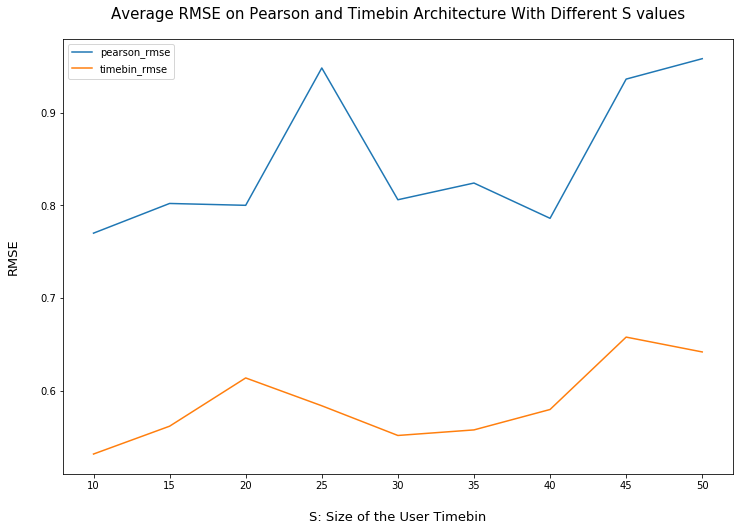

In [26]:
ax = rmse_data.groupby('s').mean().plot(figsize=(12,8))
ax.set_xlabel("S: Size of the User Timebin", labelpad=20, fontsize=13)
ax.set_ylabel("RMSE", labelpad=20, fontsize=13)
ax.set_title("Average RMSE on Pearson and Timebin Architecture With Different S values", pad=20,fontsize=15)
plt.show()

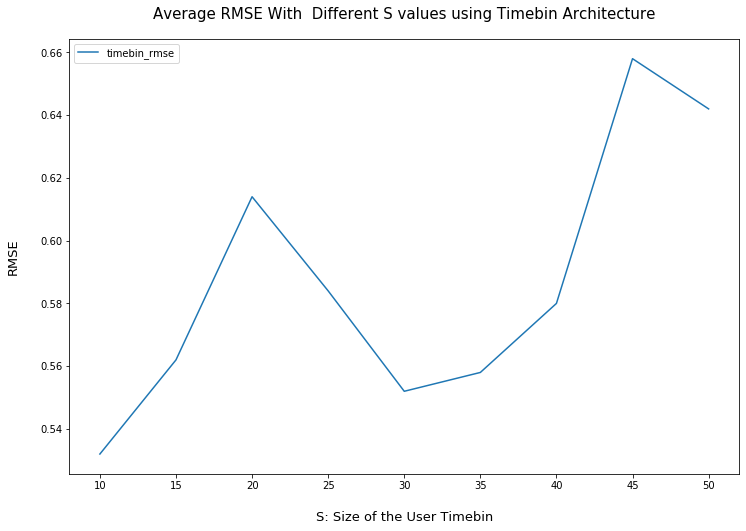

In [27]:
ax = rmse_data[['s','timebin_rmse']].groupby('s').mean().plot(figsize=(12,8))
ax.set_xlabel("S: Size of the User Timebin", labelpad=20, fontsize=13)
ax.set_ylabel("RMSE", labelpad=20, fontsize=13)
ax.set_title("Average RMSE With  Different S values using Timebin Architecture", pad=20,fontsize=15)
plt.show()

### Comparison of Pearson Vs Timebin Architecture in terms of RMSE

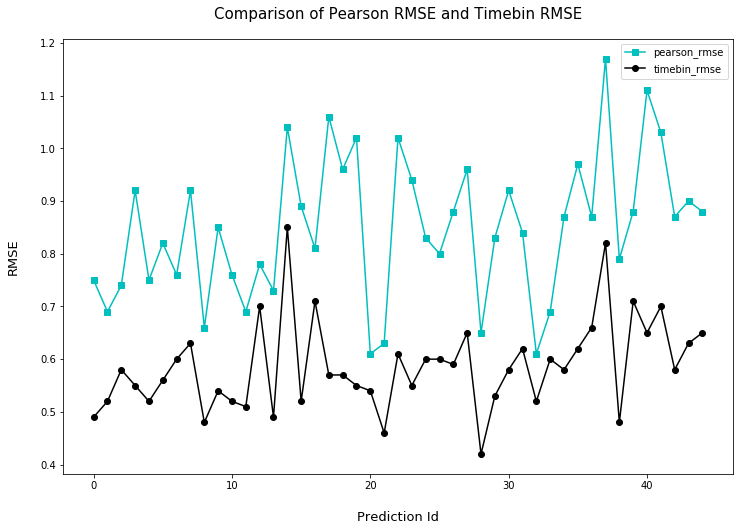

In [28]:
ax = rmse_data[['pearson_rmse', 'timebin_rmse']].plot(figsize=(12,8),style=['cs-','ko-'])
ax.set_xlabel("Prediction Id", labelpad=20, fontsize=13)
ax.set_ylabel("RMSE", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson RMSE and Timebin RMSE", pad=20,fontsize=15)
plt.show()

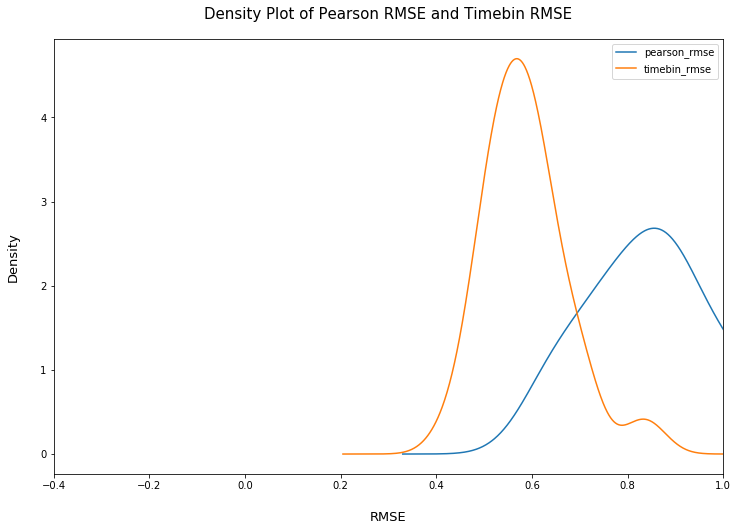

In [29]:
ax = rmse_data[['pearson_rmse', 'timebin_rmse']].plot(figsize=(12,8), kind='density',xlim=[-0.4, 1])
ax.set_xlabel("RMSE", labelpad=20, fontsize=13)
ax.set_ylabel("Density", labelpad=20, fontsize=13)
ax.set_title("Density Plot of Pearson RMSE and Timebin RMSE", pad=20,fontsize=15)
plt.show()

## Threshold Accuracy

In [30]:
def collect_threshold_accuracy_data(run_results):
    result = list()
    for run in run_results:
        s = run[0]
        normal_accuracy = NetflixAccuracy.threshold_accuracy(run[1]['normal_predictions'])
        timebin_accuracy = NetflixAccuracy.threshold_accuracy(run[1]['timebin_predictions'])
        result.append( (s, normal_accuracy, timebin_accuracy) )
    df = pd.DataFrame(result)
    df.columns = ['s', 'pearson_threshold_accuracy', 'timebin_threshold_accuracy']
    return df

In [31]:
threshold_data = collect_threshold_accuracy_data(results)
threshold_data

,s,pearson_threshold_accuracy,timebin_threshold_accuracy
0,10,0.85,0.90
1,10,0.81,0.84
2,10,0.82,0.84
3,10,0.80,0.82
4,10,0.84,0.83
5,15,0.81,0.81
6,15,0.79,0.85
7,15,0.75,0.84
8,15,0.81,0.88
9,15,0.75,0.80


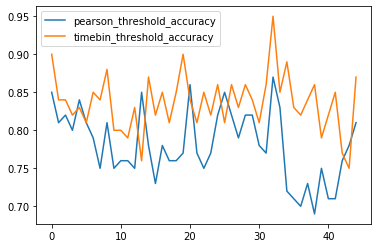

In [32]:
threshold_data[['pearson_threshold_accuracy', 'timebin_threshold_accuracy']].plot()

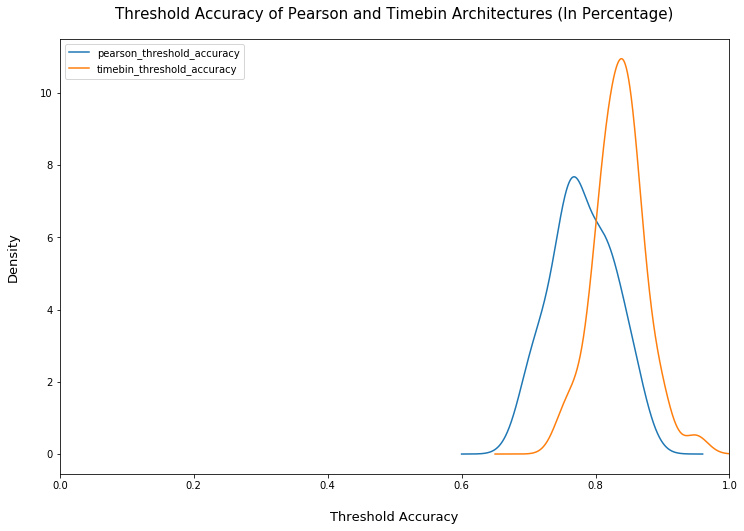

In [33]:
ax = threshold_data[['pearson_threshold_accuracy', 'timebin_threshold_accuracy']].plot(figsize=(12,8), kind='density',xlim=[0, 1])
ax.set_xlabel("Threshold Accuracy", labelpad=20, fontsize=13)
ax.set_ylabel("Density", labelpad=20, fontsize=13)
ax.set_title("Threshold Accuracy of Pearson and Timebin Architectures (In Percentage)", pad=20,fontsize=15)
plt.show()

**Population Based Analysis**

Here we see that pearson threshold accuracy is taking values in between 40 and 100 and most of the accuracy values are in between 60 and 80.

On the other hand, timebin threshold accuracy is mostly taking values between 60 and 100 and most of the accuracy values are in between 80 and 90.

In [34]:
mean_normal_threshold = threshold_data.mean()['pearson_threshold_accuracy']
mean_timebin_threshold = threshold_data.mean()['timebin_threshold_accuracy']
print(f"Mean Normal Threshold: \t{int(mean_normal_threshold * 100)} %\nMean Timebin Threshold: {int(mean_timebin_threshold * 100)} %")

Mean Normal Threshold: 	78 %
Mean Timebin Threshold: 83 %


## User Coverage

[See this article in order to understand how the coverage is being calculated](https://medium.com/@rishabhbhatia315/recommendation-system-evaluation-metrics-3f6739288870)

In [35]:
def timebin_user_coverage(run_results:list, rating_threshold=0):
    """
    Find user coverage of timebin predictions
    
    If we can make one prediction for the user, than we count the user as covered.
    Result is the number of users we cover divided by all users
    """
    user_ids = defaultdict(bool)   # user ids that we can make prediction
    
    for run in run_results:    
        # Get Run Data
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]
        
        # Make timebin based predictions
        prediction = TimebinSimilarity.predict_movie(data, k=10, min_neighbour_count=3)

        if prediction > rating_threshold:
            user_ids[user_id] = True

    return len(user_ids) / 610

In [36]:
timebin_user_coverage(results, rating_threshold=0)

0.07377049180327869

## Diversity

In [37]:
def timebin_diversity(run_results:list):
    """
    Calculate Timebin Diversity 
    
    We calculate similarity for all the combinations of users and sum them and then divide by the number of combinations. 
    """
    visited_timebins = defaultdict(bool)
    
    n = 0
    total = 0
    
    for run in run_results:
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]
        
        for prediction_data in data:
            corr                   = prediction_data[1]
            neighbour_id           = prediction_data[2]
            n_common               = prediction_data[3]
            neighbour_timebin_i    = prediction_data[4]
            neighbour_timebin_size = prediction_data[5]
            timebin_size_in_days   = prediction_data[6]

            key = f"{user_id}_{timebin_i}_{timebin_size}_{neighbour_id}_{neighbour_timebin_i}_{neighbour_timebin_size}"

            if visited_timebins[key] == False:
                total += corr
                n += 1
                visited_timebins[key] = True
    S = total / n
    return (1 - S)

In [38]:
def normal_diversity(timebin_similarity:TimebinSimilarity, run_results:list):
    """
    Calculate Diversity of the results which has been found using pearson correlation 
    
    We calculate similarity for all the combinations of users and sum them and then divide by the number of combinations. 
    """
    visited_user_pairs = defaultdict(bool)
    n = 0
    total = 0
    
    for run in run_results:
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]
        neighbours   = timebin_similarity.trainset.similarity.get_k_nearest_neighbours(user_id)
        
        for neighbour_id, corr in neighbours.iterrows():
            key = f"{user_id}_{neighbour_id}"
            
            if visited_user_pairs[key] == False:
                total += corr[0]
                n += 1
                visited_user_pairs[ key ] = True
    S = total / n
    return (1 - S)

In [39]:
normal_diversity(ts, results)

0.5143619710675764

In [40]:
timebin_diversity(results)

0.2598604876679984

In [41]:
def timebin_diversity2(timebin_similarity:TimebinSimilarity, run_results:list):
    """
    Calculate Timebin Diversity 
    
    We calculate similarity for all the combinations of users and sum them and then divide by the number of combinations. 
    """
    visited_user_pairs = defaultdict(bool)
    
    n = 0
    total = 0
    
    for run in run_results:
        user_id      = run[1]['output'][1][0]
        timebin_i    = run[1]['output'][1][1]
        timebin_size = run[1]['output'][1][2]
        data         = run[1]['output'][1][3]

        for prediction_data in data:
            corr                   = prediction_data[1]
            neighbour_id           = prediction_data[2]
            n_common               = prediction_data[3]
            neighbour_timebin_i    = prediction_data[4]
            neighbour_timebin_size = prediction_data[5]
            timebin_size_in_days   = prediction_data[6]

            key = f"{user_id}_{neighbour_id}"

            if visited_user_pairs[key] == False:
                total += corr
                n += 1
            visited_user_pairs[ key ] = True
    S = total / n
    return (1 - S)

In [42]:
timebin_diversity2(ts, results) 

0.2922397037858686

## Accuracy Analysis

In [43]:
def collect_all_timebin_predictions(run_results):
    predictions = list()
    for run in run_results:
        for prediction in run[1]['timebin_predictions']:
            predictions.append(prediction)
    return predictions

In [44]:
predictions = collect_all_timebin_predictions(results)
len(predictions)

4500

In [45]:
def collect_all_pearson_predictions(run_results):
    predictions = list()
    for run in run_results:
        for prediction in run[1]['normal_predictions']:
            predictions.append(prediction)
    return predictions

In [46]:
p_predictions = collect_all_pearson_predictions(results)
len(p_predictions)

4500

In [47]:
timebin_analysis = NetflixAccuracy.analize(predictions)

In [48]:
pearson_analysis = NetflixAccuracy.analize(p_predictions)

### Accuracy

In [49]:
accuracy_list = list()
for i in range(5):
    accuracy_list.append( (1+i, timebin_analysis['accuracy'][i]) )
accuracy_df = pd.DataFrame(accuracy_list)
accuracy_df.columns=['Rating', 'Accuracy']
accuracy_df.set_index('Rating', inplace=True)
#accuracy_df

In [50]:
timebin_analysis['accuracy']

[0.944, 0.847, 0.568, 0.475, 0.828]

In [51]:
#accuracy_df.plot(kind='bar')

In [52]:
accuracy_list2 = list()
for i in range(5):
    accuracy_list2.append( (1+i, pearson_analysis['accuracy'][i]) )
accuracy_df2 = pd.DataFrame(accuracy_list2)
accuracy_df2.columns=['Rating', 'Accuracy']
accuracy_df2.set_index('Rating', inplace=True)
#accuracy_df2

In [53]:
#accuracy_df2.plot(kind='bar')

In [54]:
acc_pair = accuracy_df.add_suffix('_Timebin').join(accuracy_df2.add_suffix('_Pearson'))
acc_pair

,Accuracy_Timebin,Accuracy_Pearson
Rating,,
1,0.944,0.934
2,0.847,0.819
3,0.568,0.513
4,0.475,0.487
5,0.828,0.805


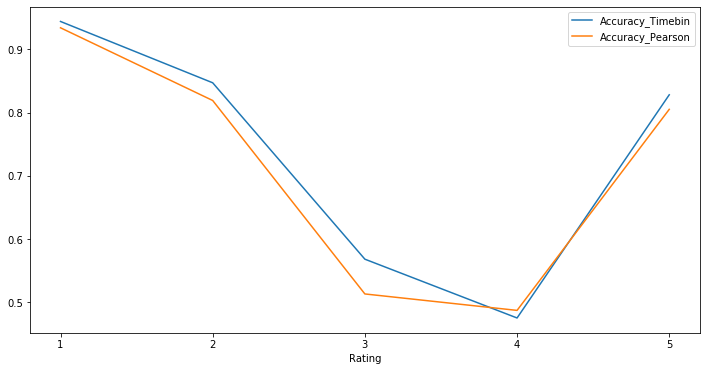

In [55]:
ax = acc_pair.plot(figsize=(12,6))
ax.set_xticks(acc_pair.index)
plt.show()

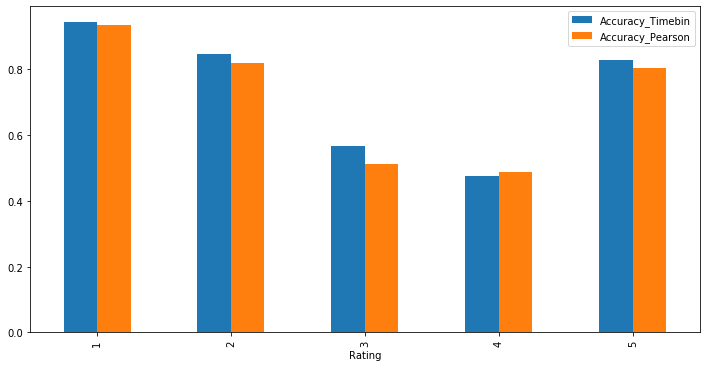

In [56]:
acc_pair.plot(kind='bar', figsize=(12,6))

### Balanced Accuracy

In [57]:
balanced_accuracy_list = list()
for i in range(5):
    balanced_accuracy_list.append( (i+1, timebin_analysis['balanced_accuracy'][i]) )
balanced_accuracy_df = pd.DataFrame(balanced_accuracy_list)
balanced_accuracy_df.columns=['Rating', 'Balanced_Accuracy']
balanced_accuracy_df.set_index('Rating', inplace=True)
#balanced_accuracy_df

In [58]:
#balanced_accuracy_df.plot(kind='bar')

In [59]:
balanced_accuracy_list2 = list()
for i in range(5):
    balanced_accuracy_list2.append( (i+1, pearson_analysis['balanced_accuracy'][i]) )
balanced_accuracy_df2 = pd.DataFrame(balanced_accuracy_list2)
balanced_accuracy_df2.columns=['Rating', 'Balanced_Accuracy']
balanced_accuracy_df2.set_index('Rating', inplace=True)
#balanced_accuracy_df2

In [60]:
#balanced_accuracy_df2.plot(kind='bar')

In [61]:
balanced_acc_pair = balanced_accuracy_df.add_suffix('_Timebin').join(balanced_accuracy_df2.add_suffix('_Pearson'))
balanced_acc_pair

,Balanced_Accuracy_Timebin,Balanced_Accuracy_Pearson
Rating,,
1,0.590,0.560
2,0.660,0.638
3,0.568,0.512
4,0.435,0.487
5,0.696,0.680


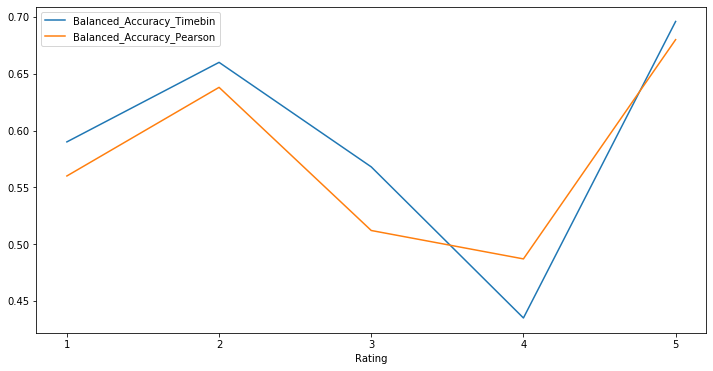

In [62]:
ax = balanced_acc_pair.plot(figsize=(12,6))
ax.set_xticks(balanced_acc_pair.index)
plt.show()

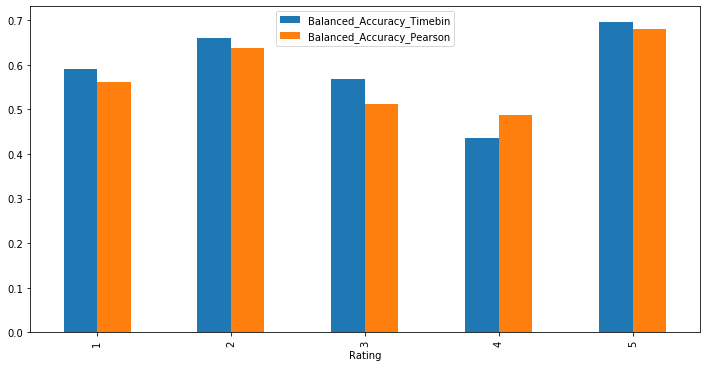

In [63]:
balanced_acc_pair.plot(kind='bar', figsize=(12,6))

### Informedness

In [64]:
informedness_list = list()
for i in range(5):
    informedness_list.append( (1+i, timebin_analysis['informedness'][i]) )
informedness_df = pd.DataFrame(informedness_list)
informedness_df.columns=['Rating', 'Informedness']
informedness_df.set_index('Rating', inplace=True)
#informedness_df

In [65]:
#informedness_df.plot(kind='bar')

In [66]:
informedness_list2 = list()
for i in range(5):
    informedness_list2.append( (1+i, pearson_analysis['informedness'][i]) )
informedness_df2 = pd.DataFrame(informedness_list2)
informedness_df2.columns=['Rating', 'Informedness']
informedness_df2.set_index('Rating', inplace=True)
#informedness_df2

In [67]:
informedness_pair = informedness_df.add_suffix('_Timebin').join(informedness_df2.add_suffix('_Pearson'))
informedness_pair

,Informedness_Timebin,Informedness_Pearson
Rating,,
1,0.181,0.120
2,0.320,0.277
3,0.137,0.023
4,-0.129,-0.026
5,0.392,0.360


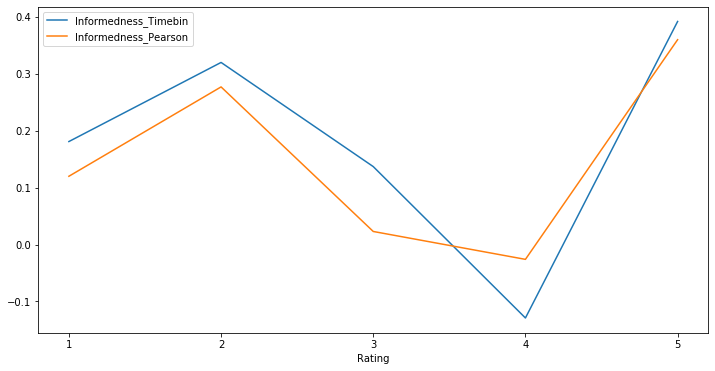

In [68]:
ax = informedness_pair.plot(figsize=(12,6))
ax.set_xticks(informedness_pair.index)
plt.show()

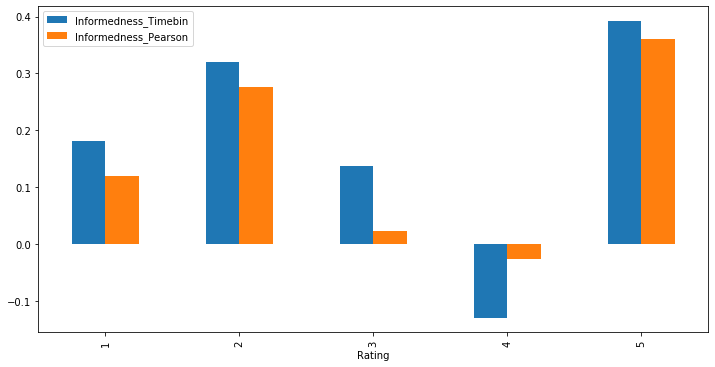

In [69]:
informedness_pair.plot(kind='bar', figsize=(12,6))

### Markedness

In [70]:
markedness_list = list()
for i in range(5):
    markedness_list.append( (1+i, timebin_analysis['markedness'][i]) )
markedness_df = pd.DataFrame(markedness_list)
markedness_df.columns=['Rating', 'Markedness']
markedness_df.set_index('Rating', inplace=True)
#markedness_df

In [71]:
#markedness_df.plot(kind='bar')

In [72]:
markedness_list2 = list()
for i in range(5):
    markedness_list2.append( (1+i, pearson_analysis['markedness'][i]) )
markedness_df2 = pd.DataFrame(markedness_list2)
markedness_df2.columns=['Rating', 'Markedness']
markedness_df2.set_index('Rating', inplace=True)
#markedness_df2

In [73]:
#markedness_df2.plot(kind='bar')

In [74]:
markedness_pair = markedness_df.add_suffix('_Timebin').join(markedness_df2.add_suffix('_Pearson'))
markedness_pair

,Markedness_Timebin,Markedness_Pearson
Rating,,
1,0.553,0.307
2,0.346,0.257
3,0.137,0.023
4,-0.161,-0.026
5,0.519,0.430


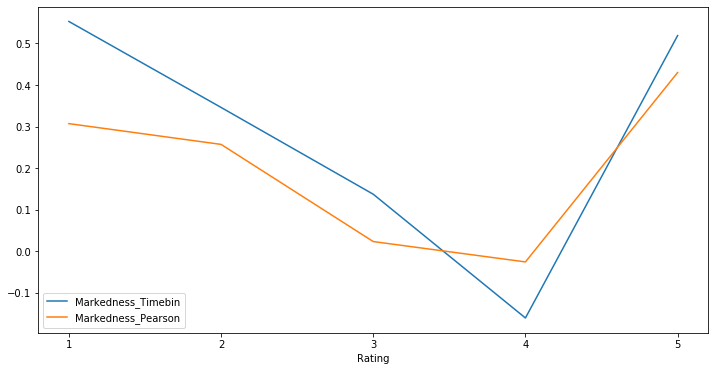

In [75]:
ax = markedness_pair.plot(figsize=(12,6))
ax.set_xticks(markedness_pair.index)
plt.show()

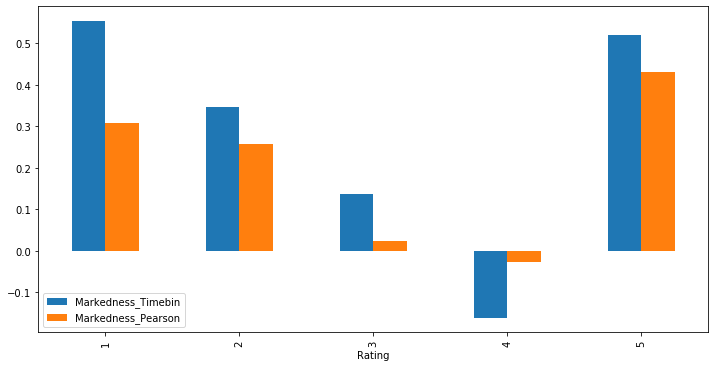

In [76]:
markedness_pair.plot(kind='bar', figsize=(12,6))

### F1

In [77]:
f1_list = list()
for i in range(5):
    f1_list.append( (1+i, timebin_analysis['f1'][i]) )
f1_df = pd.DataFrame(f1_list)
f1_df.columns=['Rating', 'f1']
f1_df.set_index('Rating', inplace=True)
#f1_df

In [78]:
#f1_df.plot(kind='bar')

In [79]:
f1_list2 = list()
for i in range(5):
    f1_list2.append( (1+i, pearson_analysis['f1'][i]) )
f1_df2 = pd.DataFrame(f1_list2)
f1_df2.columns=['Rating', 'f1']
f1_df2.set_index('Rating', inplace=True)
#f1_df2

In [80]:
#f1_df2.plot(kind='bar')

In [81]:
f1_pair = f1_df.add_suffix('_Timebin').join(f1_df2.add_suffix('_Pearson'))
f1_pair

,f1_Timebin,f1_Pearson
Rating,,
1,0.287,0.197
2,0.420,0.372
3,0.569,0.479
4,0.601,0.511
5,0.542,0.509


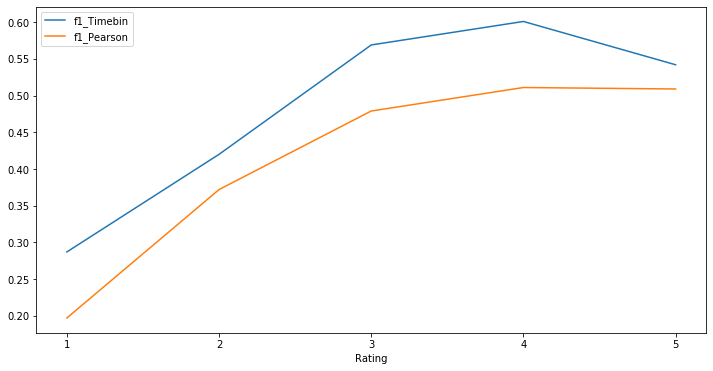

In [82]:
ax = f1_pair.plot(figsize=(12,6))
ax.set_xticks(f1_pair.index)
plt.show()

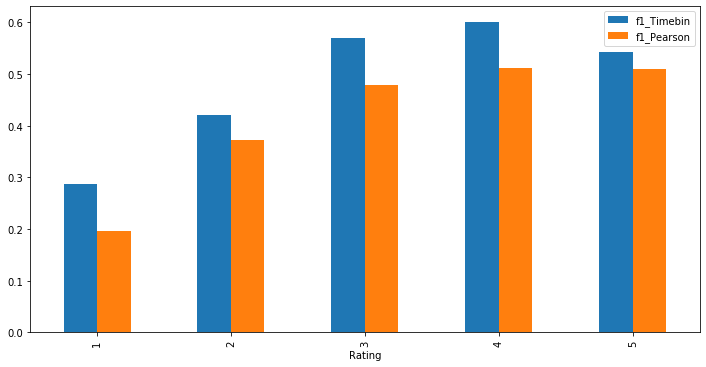

In [83]:
f1_pair.plot(kind='bar', figsize=(12,6))

### MCC

In [84]:
mcc_list = list()
for i in range(5):
    mcc_list.append( (1+i, timebin_analysis['mcc'][i]) )
mcc_df = pd.DataFrame(mcc_list)
mcc_df.columns=['Rating', 'mcc']
mcc_df.set_index('Rating', inplace=True)
#mcc_df

In [85]:
#mcc_df.plot(kind='bar')

In [86]:
mcc_list2 = list()
for i in range(5):
    mcc_list2.append( (1+i, pearson_analysis['mcc'][i]) )
mcc_df2 = pd.DataFrame(mcc_list2)
mcc_df2.columns=['Rating', 'mcc']
mcc_df2.set_index('Rating', inplace=True)
#mcc_df2

In [87]:
#mcc_df2.plot(kind='bar')

In [88]:
mcc_pair = mcc_df.add_suffix('_Timebin').join(mcc_df2.add_suffix('_Pearson'))
mcc_pair

,mcc_Timebin,mcc_Pearson
Rating,,
1,0.316,0.192
2,0.333,0.267
3,0.137,0.023
4,-0.144,-0.026
5,0.451,0.393


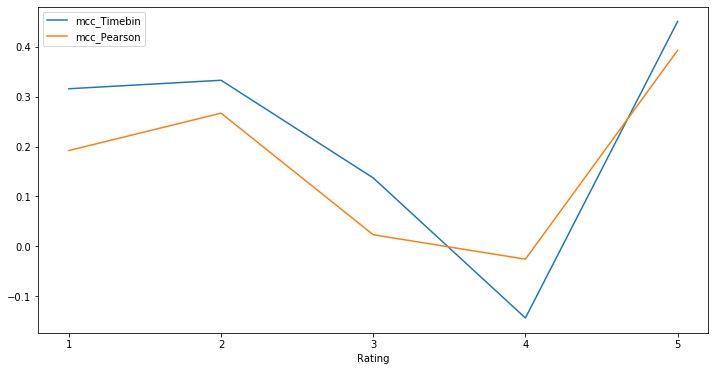

In [89]:
ax = mcc_pair.plot(figsize=(12,6))
ax.set_xticks(mcc_pair.index)
plt.show()

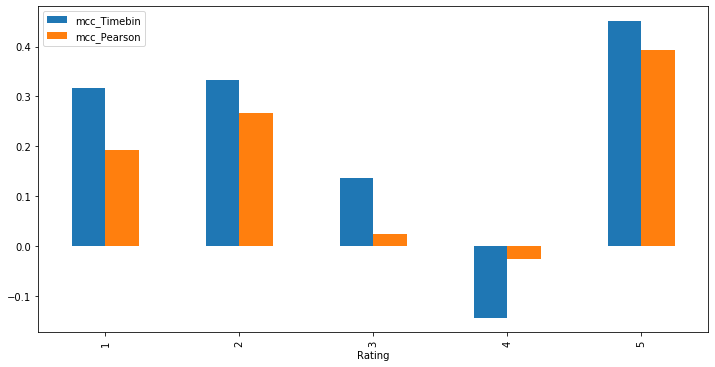

In [90]:
mcc_pair.plot(kind='bar', figsize=(12,6))

### Precision

In [91]:
precision_list = list()
for i in range(5):
    precision_list.append( (1+i, timebin_analysis['precision'][i]) )
precision_df = pd.DataFrame(precision_list)
precision_df.columns=['Rating', 'Precision']
precision_df.set_index('Rating', inplace=True)
#precision_df

In [92]:
#precision_df.plot(kind='bar')

In [93]:
precision_list2 = list()
for i in range(5):
    precision_list2.append( (1+i, pearson_analysis['precision'][i]) )
precision_df2 = pd.DataFrame(precision_list2)
precision_df2.columns=['Rating', 'Precision']
precision_df2.set_index('Rating', inplace=True)
#precision_df2

In [94]:
#precision_df2.plot(kind='bar')

In [95]:
precision_pair = precision_df.add_suffix('_Timebin').join(precision_df2.add_suffix('_Pearson'))
precision_pair

,Precision_Timebin,Precision_Pearson
Rating,,
1,0.602,0.360
2,0.440,0.356
3,0.550,0.458
4,0.538,0.487
5,0.661,0.576


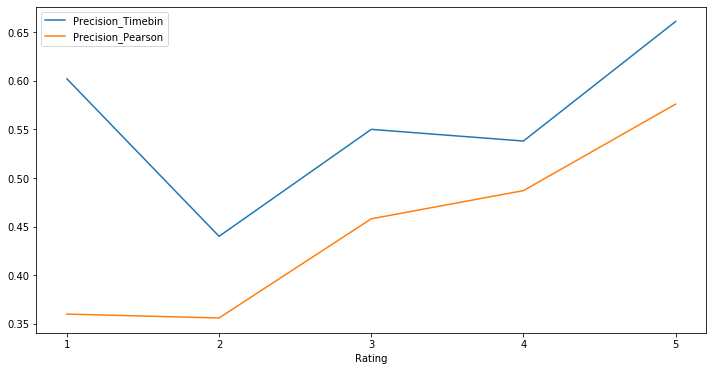

In [96]:
ax = precision_pair.plot(figsize=(12,6))
ax.set_xticks(precision_pair.index)
plt.show()

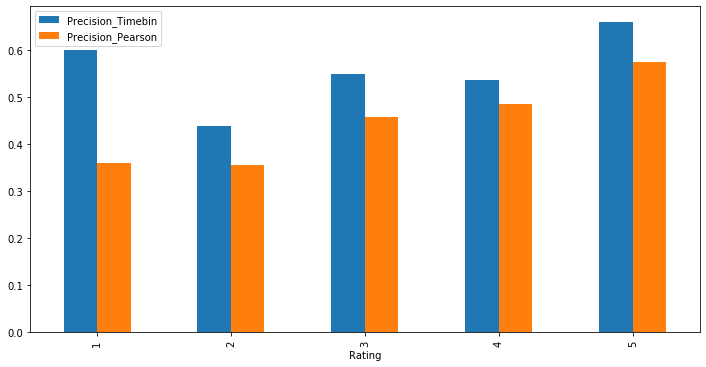

In [97]:
precision_pair.plot(kind='bar', figsize=(12,6))

### Recall

In [98]:
recall_list = list()
for i in range(5):
    recall_list.append( (1+i, timebin_analysis['recall'][i]) )
recall_df = pd.DataFrame(recall_list)
recall_df.columns=['Rating', 'Recall']
recall_df.set_index('Rating', inplace=True)
#recall_df

In [99]:
#recall_df.plot(kind='bar')

In [100]:
recall_list2 = list()
for i in range(5):
    recall_list2.append( (1+i, pearson_analysis['recall'][i]) )
recall_df2 = pd.DataFrame(recall_list2)
recall_df2.columns=['Rating', 'Recall']
recall_df2.set_index('Rating', inplace=True)
#recall_df2

In [101]:
#recall_df2.plot(kind='bar')

In [102]:
recall_pair = recall_df.add_suffix('_Timebin').join(recall_df2.add_suffix('_Pearson'))
recall_pair

,Recall_Timebin,Recall_Pearson
Rating,,
1,0.189,0.136
2,0.401,0.389
3,0.589,0.502
4,0.681,0.538
5,0.459,0.455


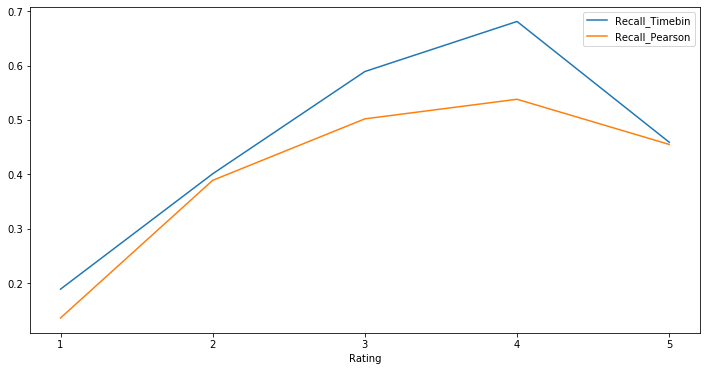

In [103]:
ax = recall_pair.plot(figsize=(12,6))
ax.set_xticks(recall_pair.index)
plt.show()

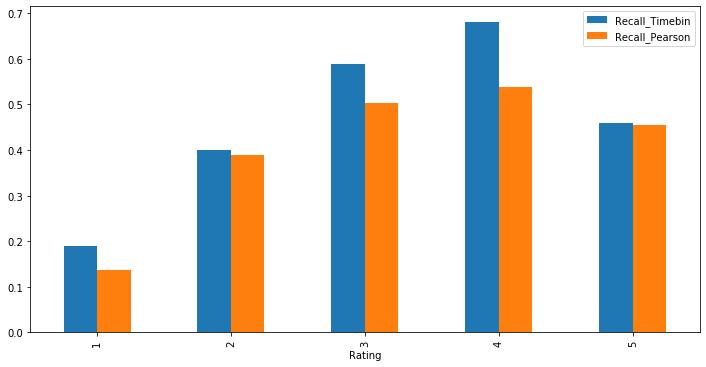

In [104]:
recall_pair.plot(kind='bar', figsize=(12,6))

### Specificity

In [105]:
specificity_list = list()
for i in range(5):
    specificity_list.append( (1+i, timebin_analysis['specificity'][i]) )
specificity_df = pd.DataFrame(specificity_list)
specificity_df.columns=['Rating', 'Specificity']
specificity_df.set_index('Rating', inplace=True)
#specificity_df

In [106]:
#specificity_df.plot(kind='bar')

In [107]:
specificity_list2 = list()
for i in range(5):
    specificity_list2.append( (1+i, pearson_analysis['specificity'][i]) )
specificity_df2 = pd.DataFrame(specificity_list2)
specificity_df2.columns=['Rating', 'Specificity']
specificity_df2.set_index('Rating', inplace=True)
#specificity_df2

In [108]:
#specificity_df2.plot(kind='bar')

In [109]:
specificity_pair = specificity_df.add_suffix('_Timebin').join(specificity_df2.add_suffix('_Pearson'))
specificity_pair

,Specificity_Timebin,Specificity_Pearson
Rating,,
1,0.992,0.985
2,0.918,0.888
3,0.548,0.521
4,0.190,0.436
5,0.933,0.905


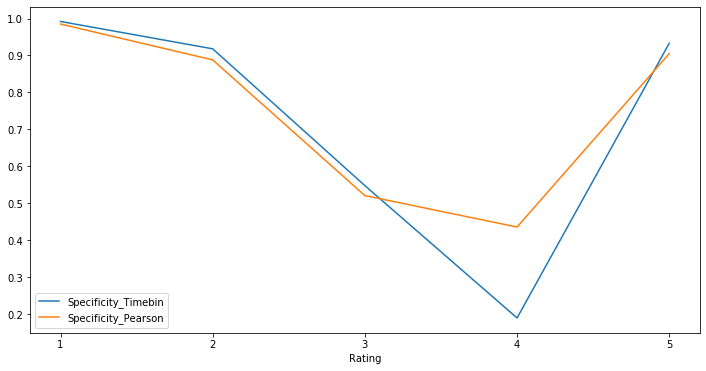

In [110]:
ax = specificity_pair.plot(figsize=(12,6))
ax.set_xticks(specificity_pair.index)
plt.show()

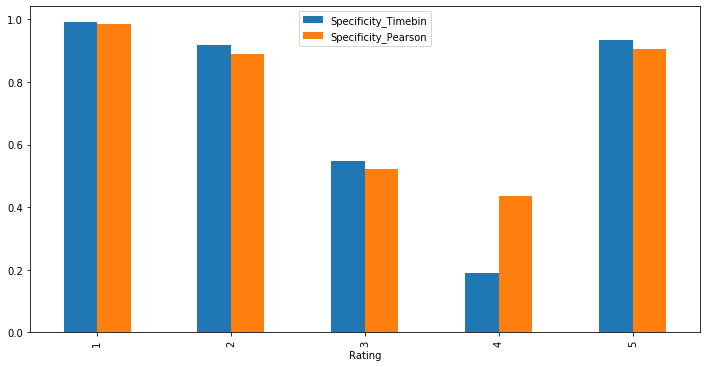

In [111]:
specificity_pair.plot(kind='bar', figsize=(12,6))

### NPV

In [112]:
npv_list = list()
for i in range(5):
    npv_list.append( (1+i, timebin_analysis['NPV'][i]) )
npv_df = pd.DataFrame(npv_list)
npv_df.columns=['Rating', 'NPV']
npv_df.set_index('Rating', inplace=True)
#npv_df

In [113]:
#npv_df.plot(kind='bar')

In [114]:
npv_list2 = list()
for i in range(5):
    npv_list2.append( (1+i, pearson_analysis['NPV'][i]) )
npv_df2 = pd.DataFrame(npv_list2)
npv_df2.columns=['Rating', 'NPV']
npv_df2.set_index('Rating', inplace=True)
#npv_df2

In [115]:
#npv_df2.plot(kind='bar')

In [116]:
npv_pair = npv_df.add_suffix('_Timebin').join(npv_df2.add_suffix('_Pearson'))
npv_pair

,NPV_Timebin,NPV_Pearson
Rating,,
1,0.950,0.947
2,0.906,0.901
3,0.587,0.565
4,0.300,0.487
5,0.858,0.854


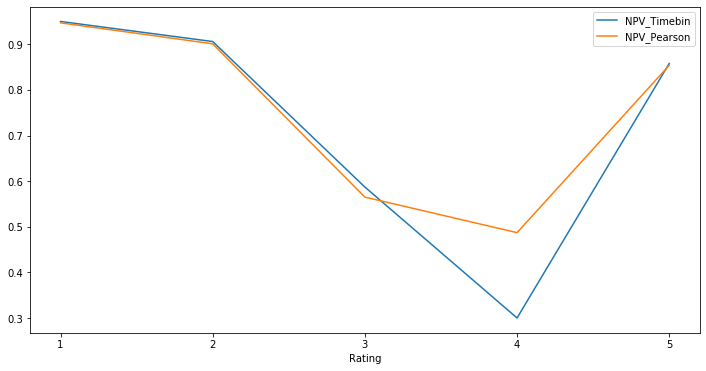

In [117]:
ax = npv_pair.plot(figsize=(12,6))
ax.set_xticks(npv_pair.index)
plt.show()

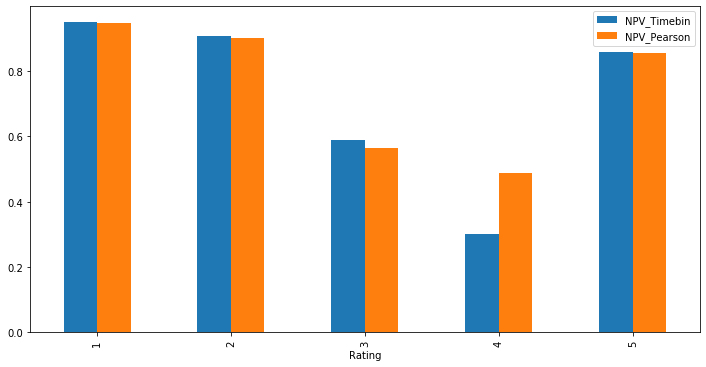

In [118]:
npv_pair.plot(kind='bar', figsize=(12,6))

### Accuracy Analysis All In One

#### NPV

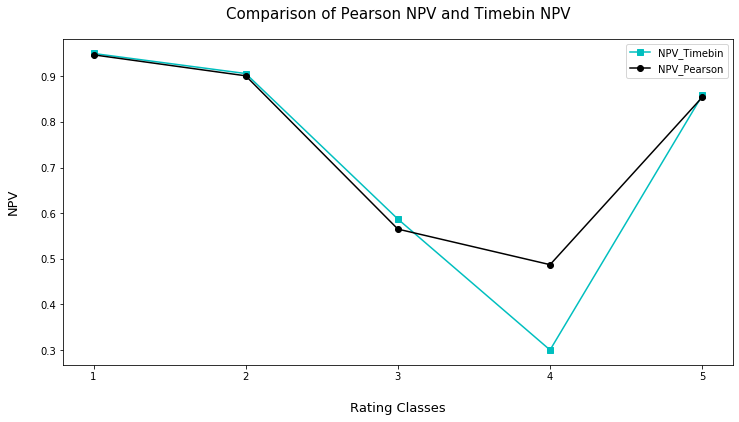

In [119]:
ax = npv_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(npv_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("NPV", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson NPV and Timebin NPV", pad=20,fontsize=15)
plt.show()

#### Specificity

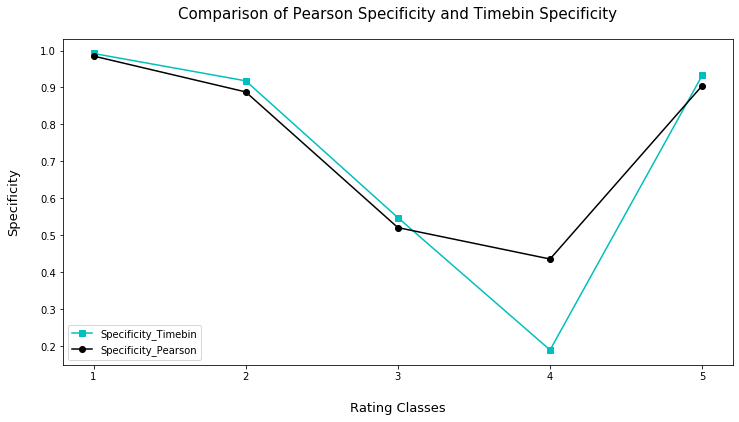

In [120]:
ax = specificity_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(specificity_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("Specificity", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson Specificity and Timebin Specificity", pad=20,fontsize=15)
plt.show()

#### Recall

Recall attempts to answer the following question:
* What proportion of actual positives was identified correctly?

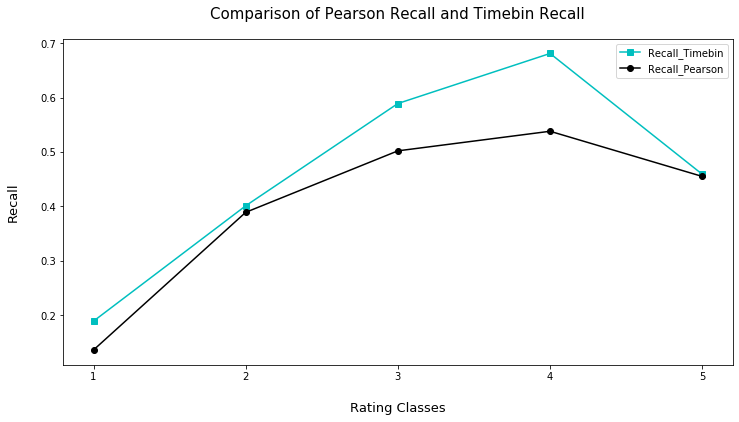

In [122]:
ax = recall_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(recall_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("Recall", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson Recall and Timebin Recall", pad=20,fontsize=15)
plt.show()

#### Precision

Precision attempts to answer the following question:

* What proportion of positive identifications was actually correct?

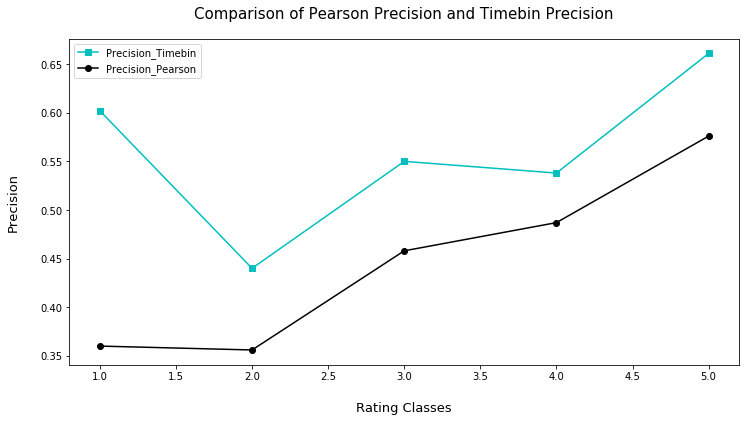

In [123]:
ax = precision_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("Precision", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson Precision and Timebin Precision", pad=20,fontsize=15)
plt.show()

#### MCC

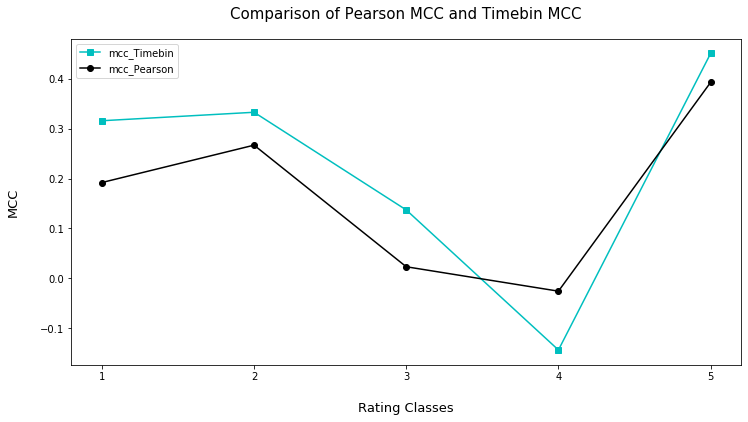

In [124]:
ax = mcc_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(mcc_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("MCC", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson MCC and Timebin MCC", pad=20,fontsize=15)
plt.show()

#### F1

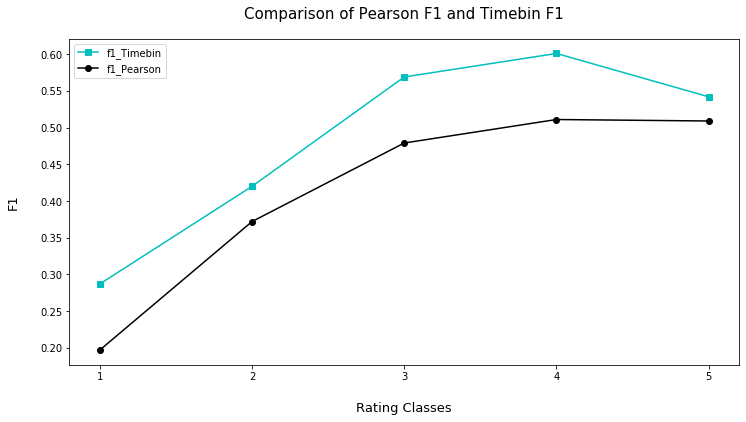

In [125]:
ax = f1_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(f1_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("F1", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson F1 and Timebin F1", pad=20,fontsize=15)
plt.show()

#### Markedness

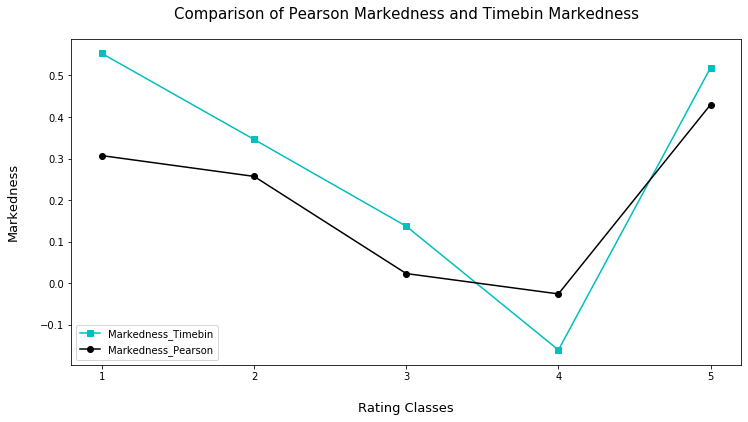

In [126]:
ax = markedness_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(markedness_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("Markedness", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson Markedness and Timebin Markedness", pad=20,fontsize=15)
plt.show()

#### Informedness

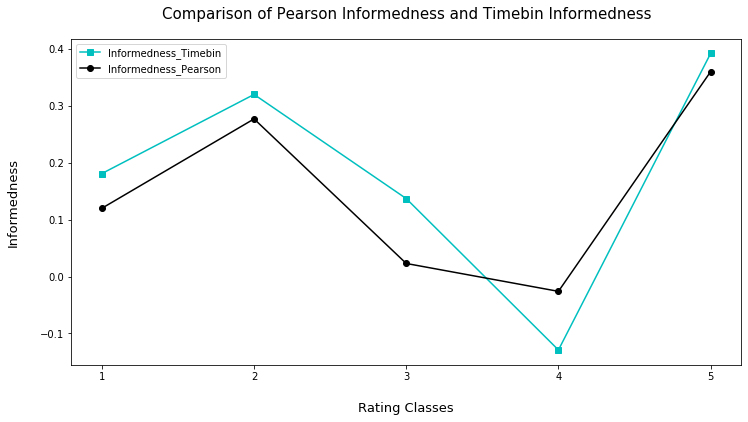

In [127]:
ax = informedness_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(informedness_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("Informedness", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson Informedness and Timebin Informedness", pad=20,fontsize=15)
plt.show()

#### Balanced Accuracy

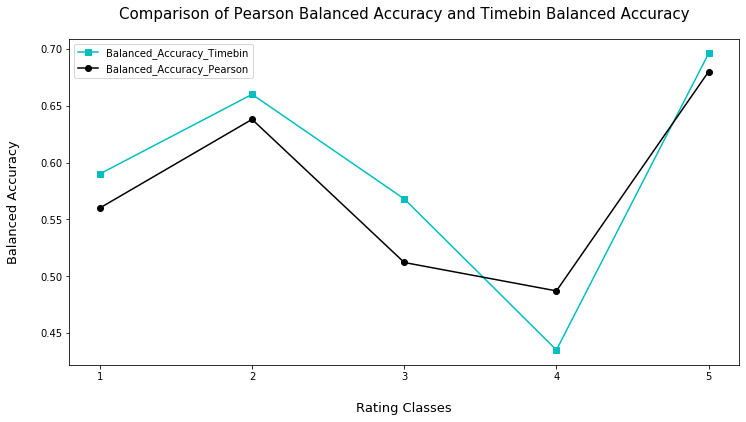

In [128]:
ax = balanced_acc_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(balanced_acc_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("Balanced Accuracy", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson Balanced Accuracy and Timebin Balanced Accuracy", pad=20,fontsize=15)
plt.show()

#### Accuracy

Accuracy is the fraction of predictions our model got right.

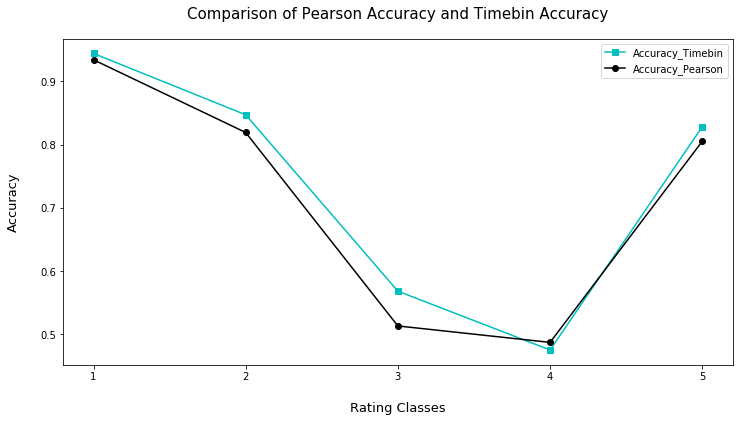

In [129]:
ax = acc_pair.plot(figsize=(12,6),style=['cs-','ko-'])
ax.set_xticks(acc_pair.index)
ax.set_xlabel("Rating Classes", labelpad=20, fontsize=13)
ax.set_ylabel("Accuracy", labelpad=20, fontsize=13)
ax.set_title("Comparison of Pearson Accuracy and Timebin Accuracy", pad=20,fontsize=15)
plt.show()